In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scanpy.api as sc
import pandas as pd
import h5py
import os
import time
import itertools
from sklearn.decomposition import PCA
import pickle

import scanpy.api as sc
import sceb.data_loader as dl 
import sceb.scdd as sd

%matplotlib inline
%load_ext autoreload
%autoreload 2

from matplotlib import rcParams

params = {
   'axes.labelsize': 16,
   'font.size': 16,
   'legend.fontsize': 10,
   'xtick.labelsize': 13,
   'ytick.labelsize': 13,
   'text.usetex': False,
   'text.usetex': False,
   }
rcParams.update(params)

/home/martin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
## 
output_folder = '/home/martin/single_cell_eb/figures/figure_subsample_specturm'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
data = dl.load_10x_4k()
sc.pp.filter_genes(data,min_counts=0.2*data.shape[0])
Nc,G,Nr,Nr_bar = sd.get_info(data)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
## Nc=4340, G=2133, Nr=3770.64, Nr_bar=1.77


# An estimation result with a specturm of subsampled dataset

In [26]:
sub_subsample_list = np.linspace(0.2,0.9,8)

marker_gene_list = ['CD3D','CD3G','CD3E','CD8A','NKG7','FCER1A','CD16','S100A8','CD79A','S100A9','CCR10','TNFRSF18',\
                   'ID3','FCER1A25','PF4','CD34','CLEC9A','GZMK','SIGLEC7','GNLY','LGALS3','CD4','CLEC4C',\
                   'PTCRA','CD8B','ID3']


gene_list = []
for gene in marker_gene_list:
    if gene in data.var_names:
        gene_list.append(gene)

In [27]:
# gene_list = ['CD3D','NKG7','S100A8',]
n_gene = len(gene_list)
n_sub_rate = len(sub_subsample_list)
n_rep = 5

size_factor = sd.dd_size_factor(data,verbose=False)
p0_ml_full,p0_dd_full = sd.dd_inactive_prob(data[:,gene_list],relative_depth=1,\
                                            size_factor=size_factor,verbose=False)
M_ml,M_dd = sd.dd_1d_moment(data[:,gene_list],verbose=False,size_factor=size_factor)
cv_ml_full = sd.M_to_cv(M_ml)
cv_dd_full = sd.M_to_cv(M_dd)

p0_ml_sub = np.zeros([n_gene,n_sub_rate,n_rep])
p0_dd_sub = np.zeros([n_gene,n_sub_rate,n_rep])
cv_ml_sub = np.zeros([n_gene,n_sub_rate,n_rep])
cv_dd_sub = np.zeros([n_gene,n_sub_rate,n_rep])

for i_sub,sub_rate in enumerate(sub_subsample_list):
    for i_rep in np.arange(n_rep):
        temp_data = sd.subsample_anndata(data,Nr*sub_rate,Nc,verbose=False,random_state=i_rep)
        size_factor = sd.dd_size_factor(temp_data,verbose=False)        
        p0_ml_sub[:,i_sub,i_rep],p0_dd_sub[:,i_sub,i_rep] = \
            sd.dd_inactive_prob(temp_data[:,gene_list],\
                                relative_depth=sub_rate,size_factor=size_factor,verbose=False)
        M_ml,M_dd = sd.dd_1d_moment(temp_data[:,gene_list],verbose=False,size_factor=size_factor)
        cv_ml_sub[:,i_sub,i_rep] = sd.M_to_cv(M_ml)
        cv_dd_sub[:,i_sub,i_rep] = sd.M_to_cv(M_dd)

In [28]:
fname = output_folder+'/data/data.pickle'
f_myfile = open(fname,'wb')
pickle.dump(p0_ml_sub, f_myfile)
pickle.dump(p0_dd_sub, f_myfile)
pickle.dump(p0_ml_full, f_myfile)
pickle.dump(p0_dd_full, f_myfile)
pickle.dump(cv_ml_sub, f_myfile)
pickle.dump(cv_dd_sub, f_myfile)
pickle.dump(cv_ml_full, f_myfile)
pickle.dump(cv_dd_full, f_myfile)
pickle.dump(gene_list, f_myfile)
pickle.dump(sub_subsample_list, f_myfile)
pickle.dump(n_rep, f_myfile)
f_myfile.close()

# Figure generation

In [3]:
fname = output_folder+'/data/data.pickle'
f_myfile = open(fname, 'rb')
p0_ml_sub = pickle.load(f_myfile)
p0_dd_sub = pickle.load(f_myfile)
p0_ml_full = pickle.load(f_myfile)
p0_dd_full = pickle.load(f_myfile)
cv_ml_sub = pickle.load(f_myfile)
cv_dd_sub = pickle.load(f_myfile)
cv_ml_full = pickle.load(f_myfile)
cv_dd_full = pickle.load(f_myfile)
gene_list = pickle.load(f_myfile)
sub_subsample_list = pickle.load(f_myfile)
n_rep = pickle.load(f_myfile)
f_myfile.close()

In [4]:
def plot_spectrum(Nr_bar,stats_ml_sub,stats_dd_sub,stats_ml_full,stats_dd_full,\
                  gene_idx,n_rep,gene_list,sub_subsample_list,y_label='',title='',fname='_'):
    n_gene = len(gene_list)
    n_sub = sub_subsample_list.shape[0]
    gene = gene_list[gene_idx]

    color_list = ['royalblue','navy','darkorange','darkred']
   
    stats_ml_mean = np.mean(stats_ml_sub[gene_idx],axis=1)
    stats_ml_std = np.std(stats_ml_sub[gene_idx],axis=1)/np.sqrt(n_rep)
    stats_dd_mean = np.mean(stats_dd_sub[gene_idx],axis=1)
    stats_dd_std = np.std(stats_dd_sub[gene_idx],axis=1)/np.sqrt(n_rep)

    plt.figure(figsize=[8,5])
    plt.plot(np.arange(n_sub),stats_ml_mean,color=color_list[3],marker='o',label='Plug-in',linewidth=3,ms=6)
    plt.errorbar(np.arange(n_sub),stats_ml_mean,stats_ml_std*3,color=color_list[3],linewidth=3)

    plt.plot(np.arange(n_sub),stats_dd_mean,color=color_list[2],marker='o',label='EB',linewidth=3,ms=6)
    plt.errorbar(np.arange(n_sub),stats_dd_mean,stats_dd_std*3,color=color_list[2],linewidth=3)

    plt.bar([n_sub-0.15],[stats_ml_full[gene_idx]],width=0.3,color=color_list[3])
    plt.bar([n_sub+0.15],[stats_dd_full[gene_idx]],width=0.3,color=color_list[2])

    plt.plot([-0.5,n_sub+0.5],[stats_ml_full[gene_idx],stats_ml_full[gene_idx]],\
             zorder=10,linestyle='dashed',linewidth=2,color='k')
    plt.plot([-0.5,n_sub+0.5],[stats_dd_full[gene_idx],stats_dd_full[gene_idx]],\
             zorder=10,linestyle='dashed',linewidth=2,color='k')

    plt.xlim([-0.5,n_sub+0.5])
    
    x_label = []
    for i in sub_subsample_list:
        x_label.append('%0.2f'%(i*Nr_bar))
    x_label.append('%0.2f(full)'%Nr_bar)
    
    plt.xticks(np.arange(n_sub+1),x_label,rotation=0,fontsize=13)
#     plt.xticks(np.arange(n_sub+1),list(sub_subsample_list*Nr_bar)+['%0.2f (Full)'%Nr_bar],rotation=0)
    plt.xlabel('mean reads per cell',fontsize=16)
    plt.ylabel(y_label+' ($\pm$ 3 std)',fontsize=16)
    plt.title(title+'%s'%gene)
    plt.legend(fontsize=13)
    # plt.grid(axis='y',linestyle='--')
    plt.tight_layout()
    plt.savefig(output_folder+'/'+fname+'_'+gene+'.png')
    plt.savefig(output_folder+'/'+fname+'_'+gene+'.pdf')
    plt.show()
    plt.close('all')

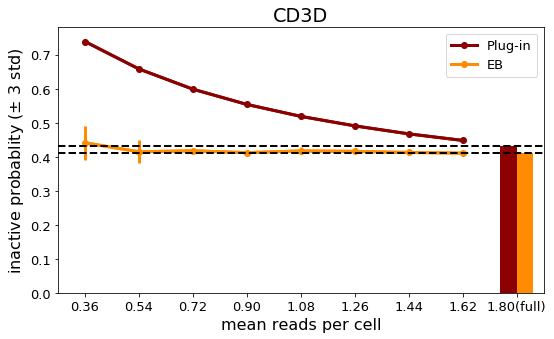

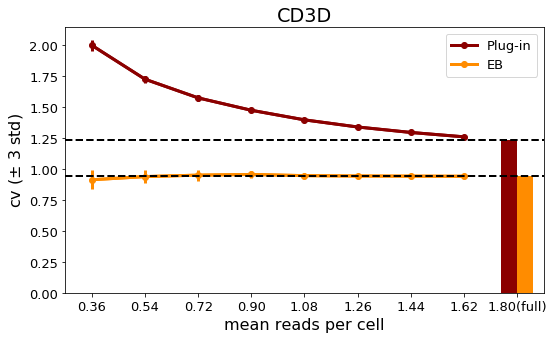

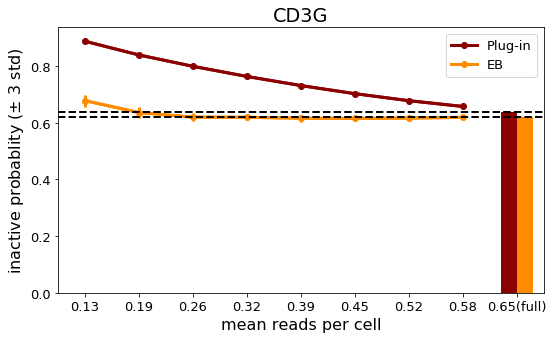

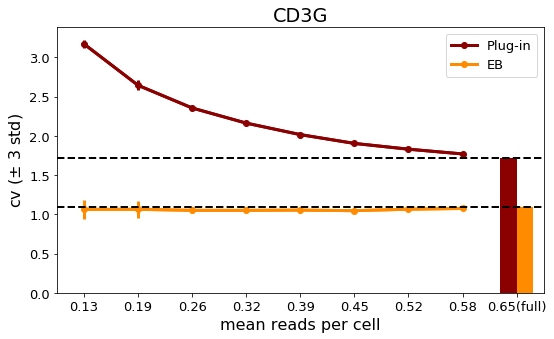

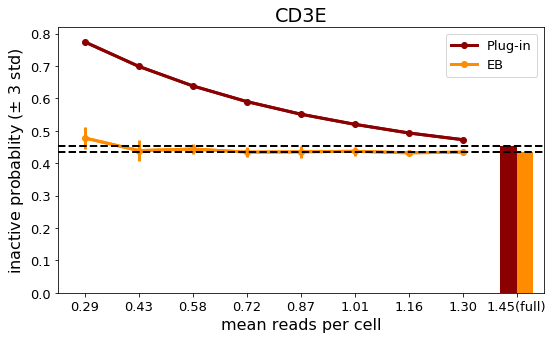

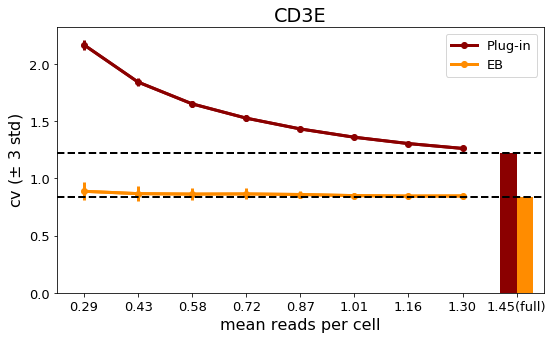

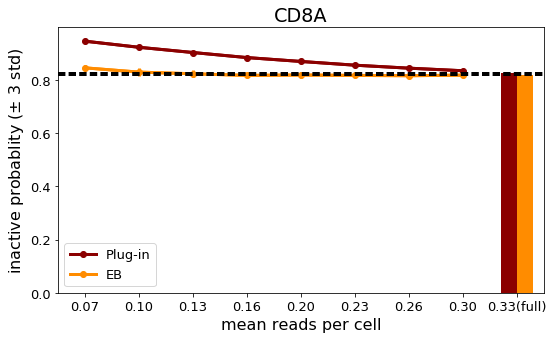

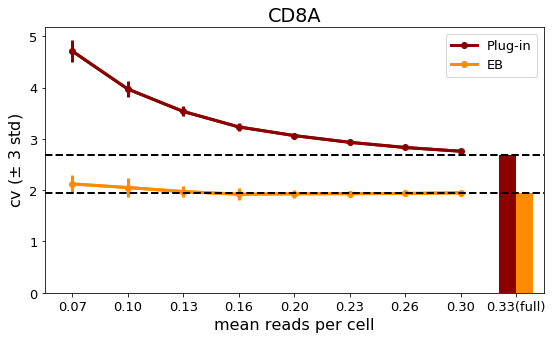

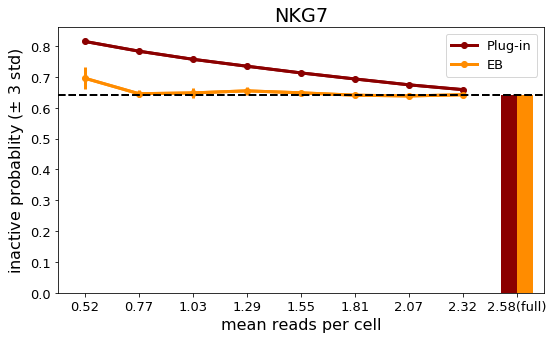

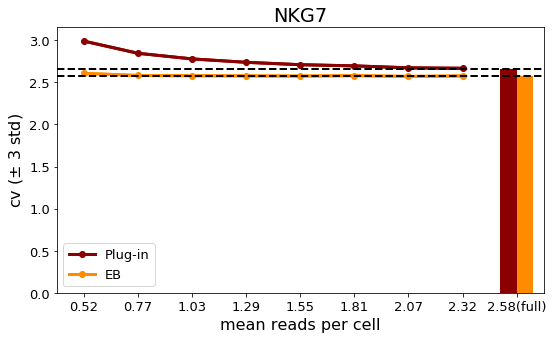

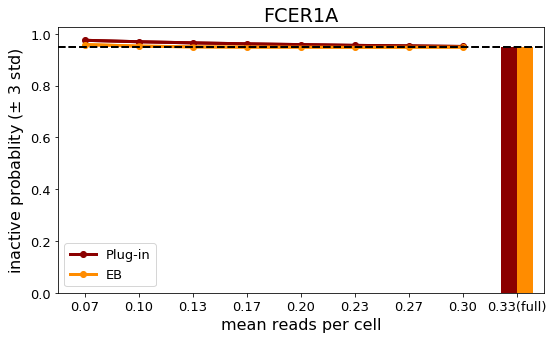

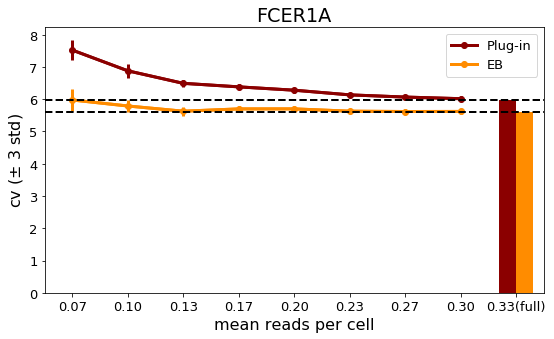

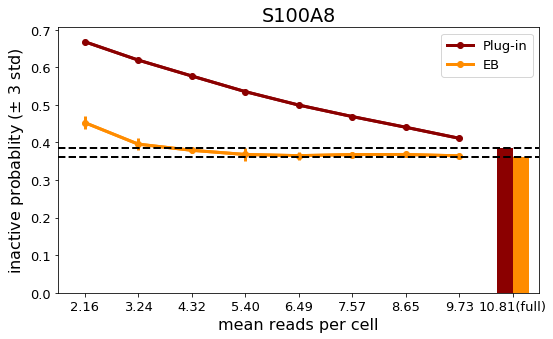

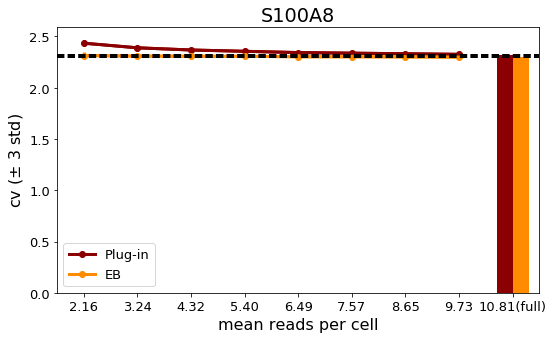

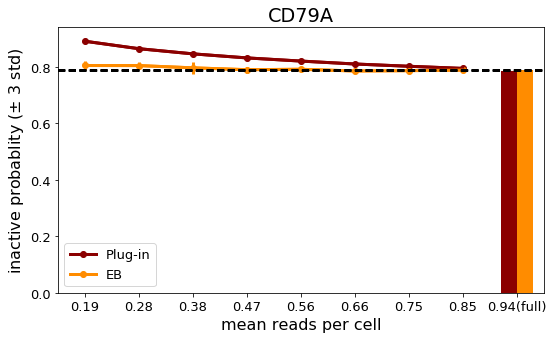

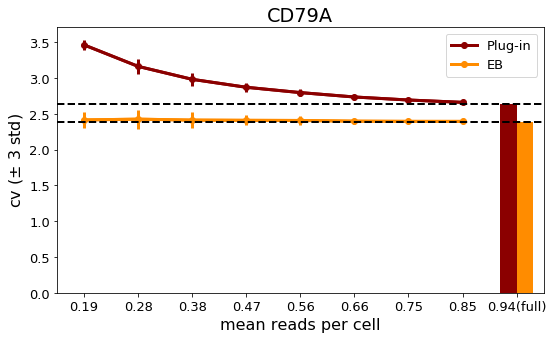

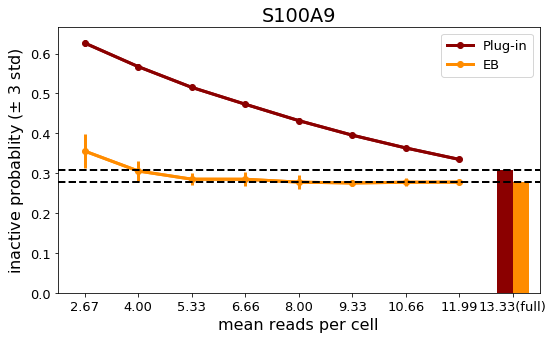

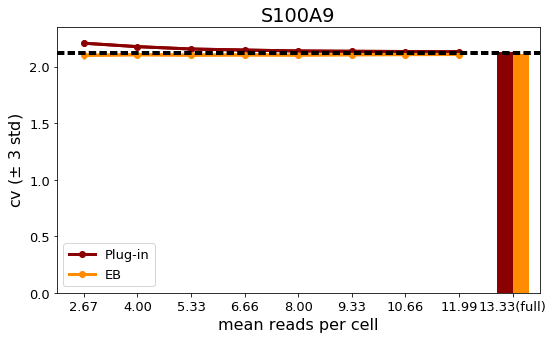

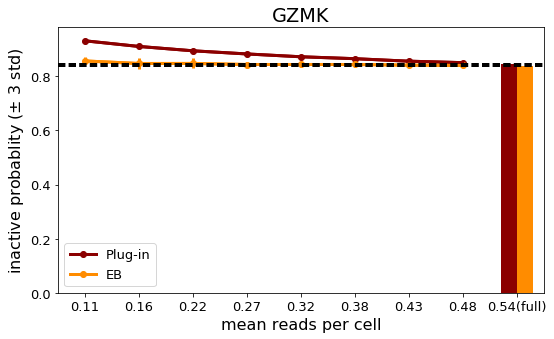

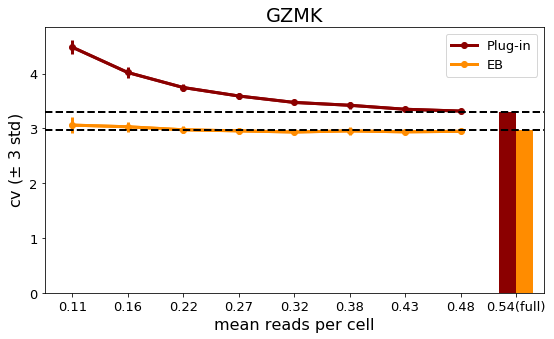

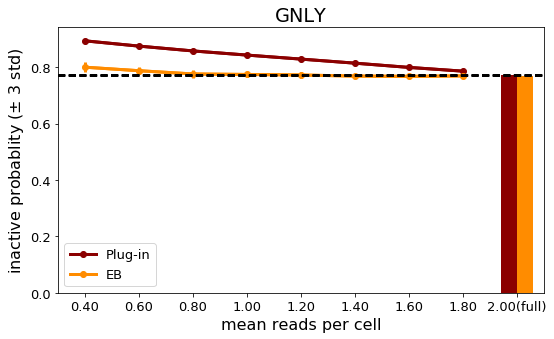

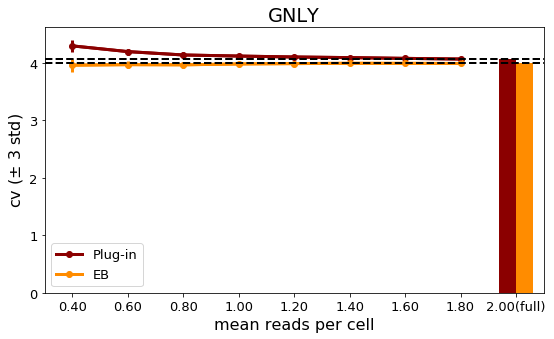

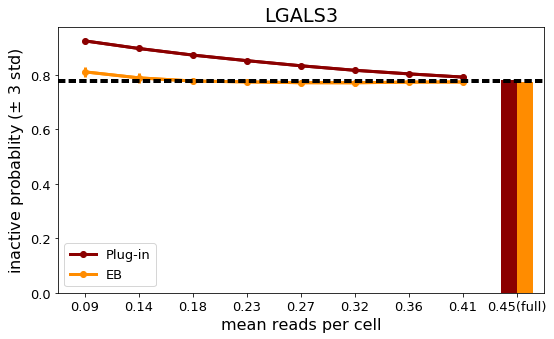

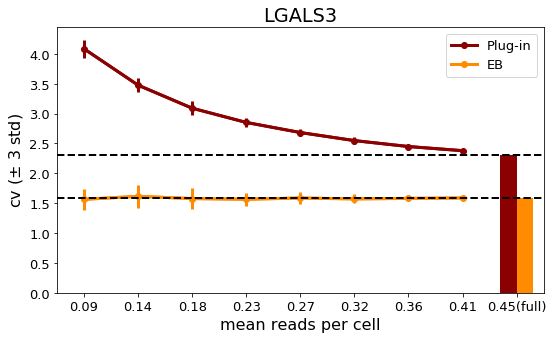

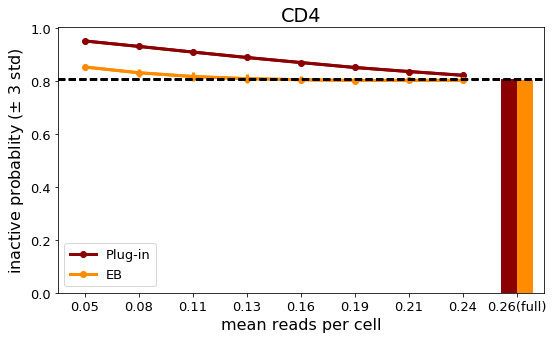

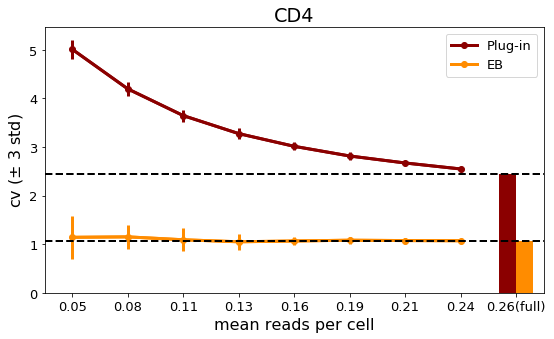

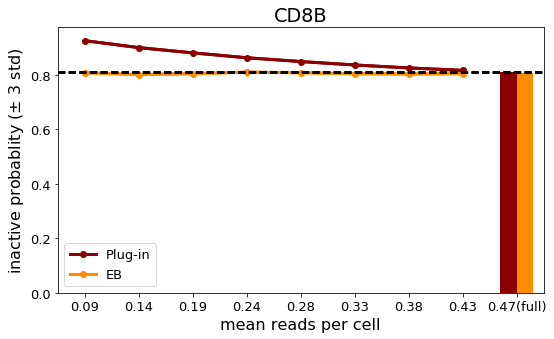

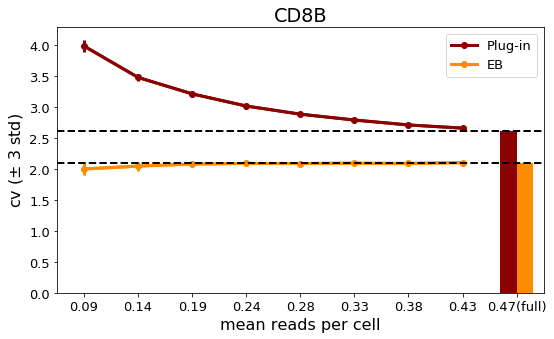

In [5]:
gene_idx = 0
for gene_idx,gene in enumerate(gene_list):
    Nr_bar = data[:,gene].X.mean()
    plot_spectrum(Nr_bar,p0_ml_sub,p0_dd_sub,p0_ml_full,p0_dd_full,\
                  gene_idx,n_rep,gene_list,sub_subsample_list,\
                  y_label='inactive probablity',title='',fname='inactive_sub_spectrum')
    plot_spectrum(Nr_bar,cv_ml_sub,cv_dd_sub,cv_ml_full,cv_dd_full,\
                  gene_idx,n_rep,gene_list,sub_subsample_list,\
                  y_label='cv',title='',fname='cv_sub_spectrum')
#     break

# Old code

In [16]:
n_gene = len(gene_list)
n_sub = sub_subsample_list.shape[0]
gene_idx = 0
gene = gene_list[gene_idx]


p0_ml_mean = np.mean(p0_ml_sub[gene_idx],axis=1)
p0_ml_std = np.std(p0_ml_sub[gene_idx],axis=1)/np.sqrt(n_rep)
p0_dd_mean = np.mean(p0_dd_sub[gene_idx],axis=1)
p0_dd_std = np.std(p0_dd_sub[gene_idx],axis=1)/np.sqrt(n_rep)
cv_ml_mean = np.mean(cv_ml_sub[gene_idx],axis=1)
cv_ml_std = np.std(cv_ml_sub[gene_idx],axis=1)/np.sqrt(n_rep)
cv_dd_mean = np.mean(cv_dd_sub[gene_idx],axis=1)
cv_dd_std = np.std(cv_dd_sub[gene_idx],axis=1)/np.sqrt(n_rep)

plt.figure(figsize=[12,5])
plt.bar(np.arange(n_sub)-0.15,p0_ml_mean,width=0.3,color=color_list[3],label='Plug-in')
plt.bar(np.arange(n_sub)+0.15,p0_dd_mean,width=0.3,color=color_list[2],label='EB')
plt.bar([n_sub-0.15],[p0_dd_full[gene_idx]],width=0.3,color=color_list[0])
plt.bar([n_sub+0.15],[p0_ml_full[gene_idx]],width=0.3,color=color_list[1])
plt.plot([-0.5,n_sub+0.5],[p0_dd_full[gene_idx],p0_dd_full[gene_idx]],linestyle='dashed',linewidth=3)
plt.xlim([-0.5,n_sub+0.5])
plt.xticks(np.arange(n_sub+1),list(sub_subsample_list)+['1 (Full)'],rotation=0)
plt.xlabel('Relative depth')
plt.title('Inactive probability, %s'%gene)
plt.legend()
plt.grid(axis='y',linestyle='--')
plt.savefig(output_folder+'/inactive_sub_spectrum.png')
plt.savefig(output_folder+'/inactive_sub_spectrum.pdf')
plt.show()
plt.close('all')

plt.figure(figsize=[12,5])
# plt.bar(np.arange(n_sub)-0.15,cv_ml_mean,width=0.3,color=color_list[3],label='Plug-in')
plt.plot(np.arange(n_sub),cv_ml_mean,color=color_list[3],marker='o',label='Plug-in',linewidth=4)
plt.errorbar(np.arange(n_sub),cv_ml_mean,cv_ml_std*3,color=color_list[3],linewidth=4)
# plt.bar(np.arange(n_sub)+0.15,cv_dd_mean,width=0.3,color=color_list[2],label='EB')
plt.plot(np.arange(n_sub),cv_dd_mean,color=color_list[2],marker='o',label='Plug-in',linewidth=4)
plt.errorbar(np.arange(n_sub),cv_dd_mean,cv_dd_std*3,color=color_list[2],linewidth=4)

plt.bar([n_sub-0.15],[cv_ml_full[gene_idx]],width=0.3,color=color_list[3])
plt.bar([n_sub+0.15],[cv_dd_full[gene_idx]],width=0.3,color=color_list[2])

plt.plot([-0.5,n_sub+0.5],[cv_ml_full[gene_idx],cv_ml_full[gene_idx]],linestyle='dashed',linewidth=2,color='k')
plt.plot([-0.5,n_sub+0.5],[cv_dd_full[gene_idx],cv_dd_full[gene_idx]],linestyle='dashed',linewidth=2,color='k')

plt.xlim([-0.5,n_sub+0.5])
plt.xticks(np.arange(n_sub+1),list(sub_subsample_list)+['1 (Full)'],rotation=0)
plt.xlabel('Relative depth')
plt.title('CV estimation, %s'%gene)
plt.legend()
# plt.grid(axis='y',linestyle='--')
plt.savefig(output_folder+'/cv_sub_spectrum.png')
plt.savefig(output_folder+'/cv_sub_spectrum.pdf')
plt.show()
plt.close('all')


NameError: name 'color_list' is not defined

<Figure size 864x360 with 0 Axes>

# Zero analysis new

In [42]:
# marker_gene_list = ['CD3D','CD3G','CD3E','CD8A','NKG7','FCER1A','CD16','S100A8','CD79A','S100A9','CCR10','TNFRSF18',\
#                    'ID3','FCER1A25','PF4','CD34','CLEC9A','GZMK','SIGLEC7','GNLY','LGALS3','CD4','CLEC4C',\
#                    'PTCRA','CD8B','ID3']


# gene_list = []
# for gene in marker_gene_list:
#     if gene in data.var_names:
#         gene_list.append(gene)

In [138]:
gene_list = ['CD3D','NKG7','S100A8',]
n_gene = len(gene_list)
n_sub_rate = len(sub_subsample_list)

size_factor = sd.dd_size_factor(data,verbose=False)
p0_ml_full,p0_dd_full = sd.dd_inactive_prob(\
                            data[:,gene_list],relative_depth=1,size_factor=size_factor,verbose=False)
M_ml,M_dd = sd.dd_1d_moment(data[:,gene_list],verbose=False,size_factor=size_factor)
cv_ml_full = sd.M_to_cv(M_ml)
cv_dd_full = sd.M_to_cv(M_dd)

p0_ml_sub,p0_dd_sub = np.zeros([n_gene,n_sub_rate]),np.zeros([n_gene,n_sub_rate])
cv_ml_sub,cv_dd_sub = np.zeros([n_gene,n_sub_rate]),np.zeros([n_gene,n_sub_rate])

for i_sub,sub_rate in enumerate(sub_subsample_list):
    size_factor = sd.dd_size_factor(data_subsample_dic[sub_rate],verbose=False)
    p0_ml_sub[:,i_sub],p0_dd_sub[:,i_sub] = \
        sd.dd_inactive_prob(data_subsample_dic[sub_rate][:,gene_list],\
        relative_depth=1/sub_rate,size_factor=size_factor,verbose=False)

    M_ml,M_dd = sd.dd_1d_moment(data_subsample_dic[sub_rate][:,gene_list],verbose=False,size_factor=size_factor)
    cv_ml_sub[:,i_sub] = sd.M_to_cv(M_ml)
    cv_dd_sub[:,i_sub] = sd.M_to_cv(M_dd)

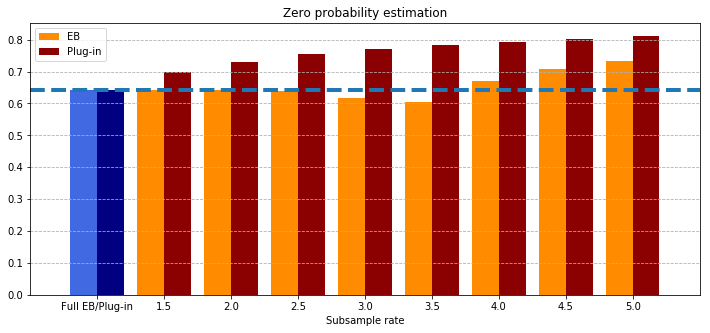

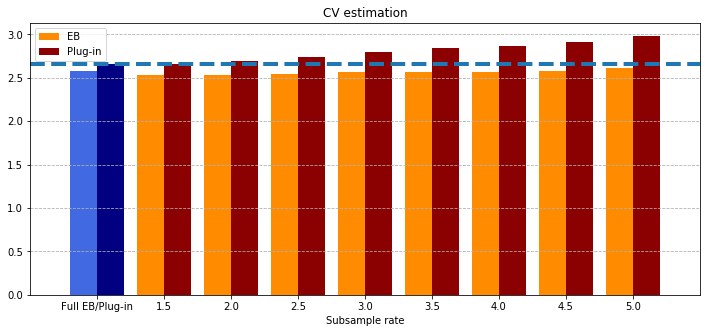

In [139]:
color_list = ['royalblue','navy','darkorange','darkred']
n_gene = len(gene_list)
sub_subsample_list = np.array(sub_subsample_list)
gene_idx = 1

plt.figure(figsize=[12,5])
plt.bar(sub_subsample_list-0.1,p0_dd_sub[gene_idx],width=0.2,color=color_list[2],label='EB')
plt.bar(sub_subsample_list+0.1,p0_ml_sub[gene_idx],width=0.2,color=color_list[3],label='Plug-in')
plt.bar([0.9],[p0_dd_full[gene_idx]],width=0.2,color=color_list[0])
plt.bar([1.1],[p0_ml_full[gene_idx]],width=0.2,color=color_list[1])
plt.plot([0.5,5.5],[p0_ml_full[gene_idx],p0_ml_full[gene_idx]],linestyle='dashed',linewidth=4)
plt.xlim([0.5,5.5])
plt.xticks([1]+list(sub_subsample_list),['Full EB/Plug-in']+list(sub_subsample_list),rotation=0)
plt.xlabel('Subsample rate')
plt.title('Zero probability estimation')
plt.legend()
plt.grid(axis='y',linestyle='--')
plt.savefig(output_folder+'/zero_estimation_sub_spectrum.png')
plt.savefig(output_folder+'/zero_estimation_sub_spectrum.pdf')
plt.show()
plt.close('all')

color_list = ['royalblue','navy','darkorange','darkred']
n_gene = len(gene_list)
plt.figure(figsize=[12,5])
plt.bar(sub_subsample_list-0.1,cv_dd_sub[gene_idx],width=0.2,color=color_list[2],label='EB')
plt.bar(sub_subsample_list+0.1,cv_ml_sub[gene_idx],width=0.2,color=color_list[3],label='Plug-in')

plt.bar([0.9],[cv_dd_full[gene_idx]],width=0.2,color=color_list[0])
plt.bar([1.1],[cv_ml_full[gene_idx]],width=0.2,color=color_list[1])
plt.plot([0.5,5.5],[cv_ml_full[gene_idx],cv_ml_full[gene_idx]],linestyle='dashed',linewidth=4)
plt.xlim([0.5,5.5])
plt.xticks([1]+list(sub_subsample_list),['Full EB/Plug-in']+list(sub_subsample_list),rotation=0)
plt.xlabel('Subsample rate')

plt.title('CV estimation')
plt.legend()
plt.grid(axis='y',linestyle='--')
plt.savefig(output_folder+'/cv_sub_spectrum.png')
plt.savefig(output_folder+'/cv_sub_spectrum.pdf')
plt.show()
plt.close('all')

array([[1.17924008, 1.14852541, 1.11190272, 1.13000542, 0.99839115,
        0.99229898, 0.98680086, 0.96745641],
       [2.62305033, 2.67876547, 2.6120617 , 2.68975634, 2.68240698,
        2.65898754, 2.71095038, 2.75004195]])

In [38]:
data_subsample_dic[sub_rate]

AnnData object with n_obs × n_vars = 4340 × 2133 
    var: 'n_counts'

In [ ]:
n_gene = len(gene_list)
plt.figure(figsize=[80,12])
for i_gene,gene in enumerate(gene_list):
    Y = np.array(data[:,gene].X)
    Y_sub = np.array(data_subsample[:,gene].X)    
    plt.subplot(2,n_gene,i_gene+1)
    plt.title('%s, Nr_bar=%0.2f'%(gene,Y.mean()))
    bins_ = np.linspace(-0.5,Y.max()+0.5,int(Y.max()+2))
    plt.hist(Y,bins=bins_)
    plt.subplot(2,n_gene,i_gene+1+n_gene)
    plt.hist(Y_sub,bins=bins_)
    plt.title('%s, Nr_bar=%0.2f'%(gene,Y_sub.mean()))
# plt.show()
plt.savefig(output_folder+'/histogram_marker_gene.png')
plt.savefig(output_folder+'/histogram_marker_gene.png')
plt.close('all')

In [ ]:
p0_ml_full,p0_dd_full = sd.dd_zero_prob(data[:,gene_list],verbose=True)
p0_ml_sub,p0_dd_sub = sd.dd_zero_prob(data_subsample[:,gene_list],verbose=True)

In [ ]:
color_list = ['royalblue','navy','darkorange','darkred']
n_gene = len(gene_list)
plt.figure(figsize=[18,8])

plt.bar(np.arange(n_gene)+0.1,p0_dd_full,width=0.2,color=color_list[0],label='dd_full')
plt.bar(np.arange(n_gene)+0.3,p0_ml_full,width=0.2,color=color_list[1],label='ml_full')
plt.bar(np.arange(n_gene)+0.5,p0_dd_sub,width=0.2,color=color_list[2],label='dd_sub')
plt.bar(np.arange(n_gene)+0.7,p0_ml_sub,width=0.2,color=color_list[3],label='ml_sub')
plt.xticks(np.arange(n_gene)+0.25,gene_list,rotation=45)
plt.title('Estimation result')
plt.legend()
plt.grid(axis='y',linestyle='--')
plt.savefig(output_folder+'/zero_estimation_marker_gene.png')
# plt.show()
plt.close('all')

# Zero component analysis for highly-expressed genes

In [29]:
data = sc.pp.filter_genes(data_raw,min_counts=0.5*data_raw.shape[0],copy=True)
Nc,G,Nr,Nr_bar = sd.get_info(data)
Nr_sub = Nr/2
print('## Nc=%d, G=%d, Nr=%0.1f, Nr_sub=%0.1f'%(Nc,G,Nr,Nr_sub))  
data_subsample = sd.subsample_anndata(data,Nr_sub,Nc)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
## Nc=4340, G=810, Nr=3363.4, Nr_bar=4.2
## Nc=4340, G=810, Nr=3363.4, Nr_sub=1681.7
#time start: 0.0s
before cell subsamp (4340, 810)
after cell subsamp (4340, 810)
#time sub-sample cells: 0.0240s
#time sub-sample counts: 6.8329s



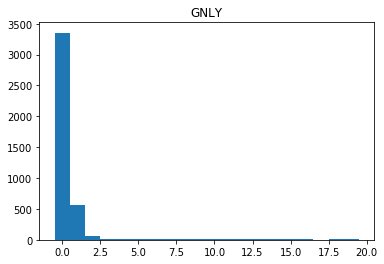

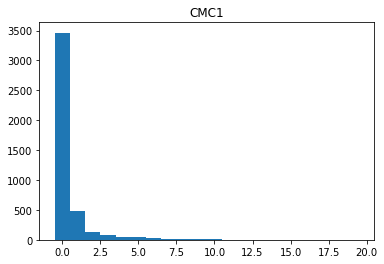

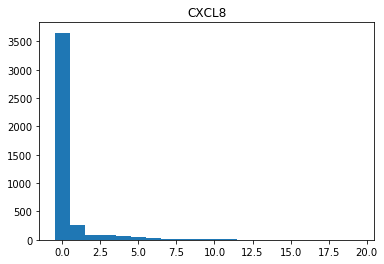

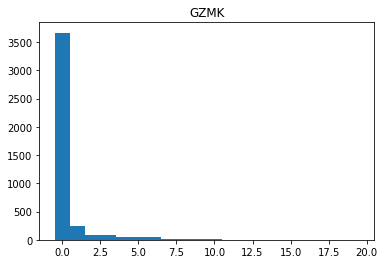

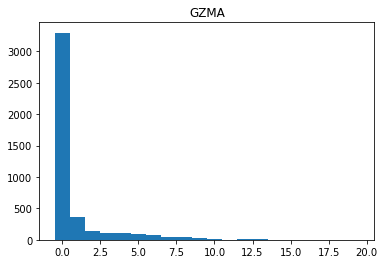

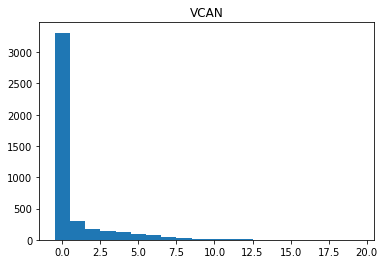

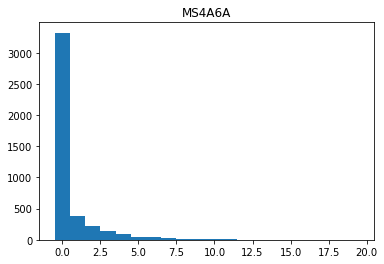

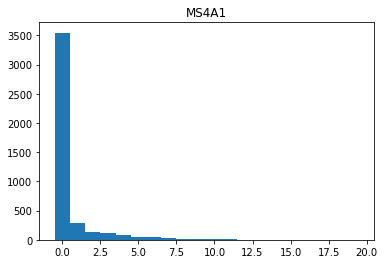

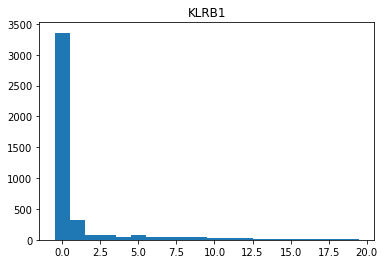

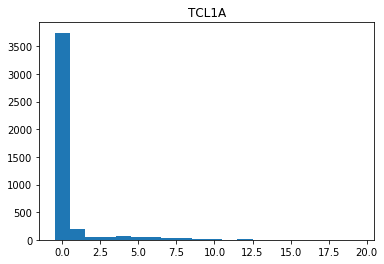

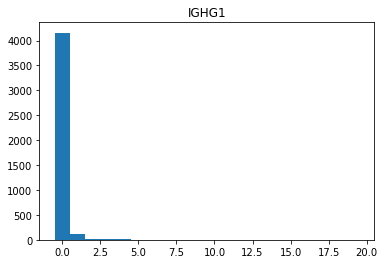

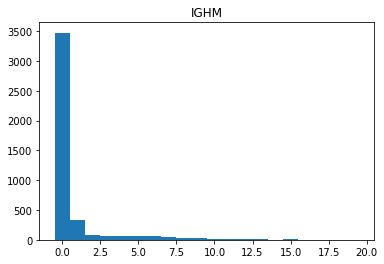

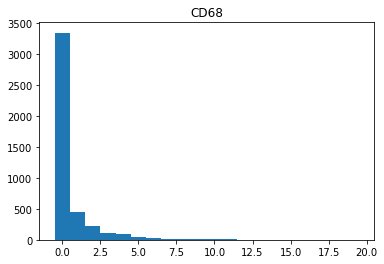

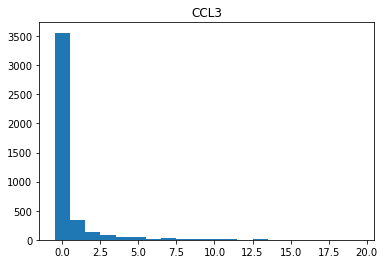

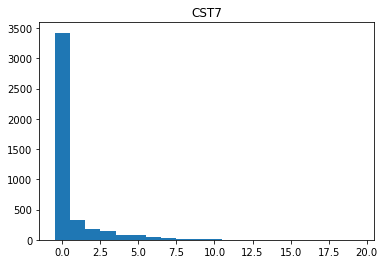

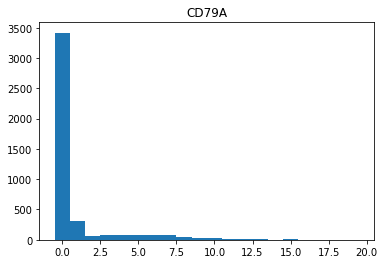

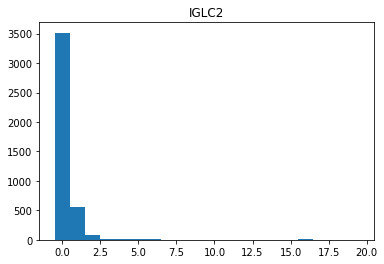

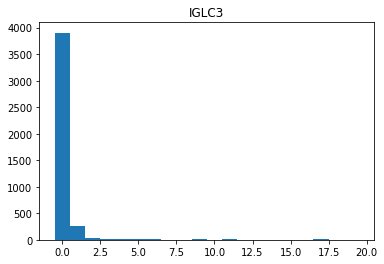

In [30]:
gene_list = []
for gene in list(data.var_names):
    Y = np.array(data[:,gene].X).astype(int)
    if np.mean(Y==0)>0.75:
        gene_list.append(gene)
        plt.figure()
        plt.hist(Y,bins=np.linspace(-0.5,19.5,21))
        plt.title(gene)
        plt.show()

In [31]:
p0_ml_full,p0_dd_full = sd.dd_zero_prob(data[:,gene_list],verbose=True)
p0_ml_sub,p0_dd_sub = sd.dd_zero_prob(data_subsample[:,gene_list],verbose=True)

# time start: 0.0s
n_cell=4340, n_gene=18
# total time: 0.0s
# time start: 0.0s
n_cell=4340, n_gene=18
# total time: 0.0s


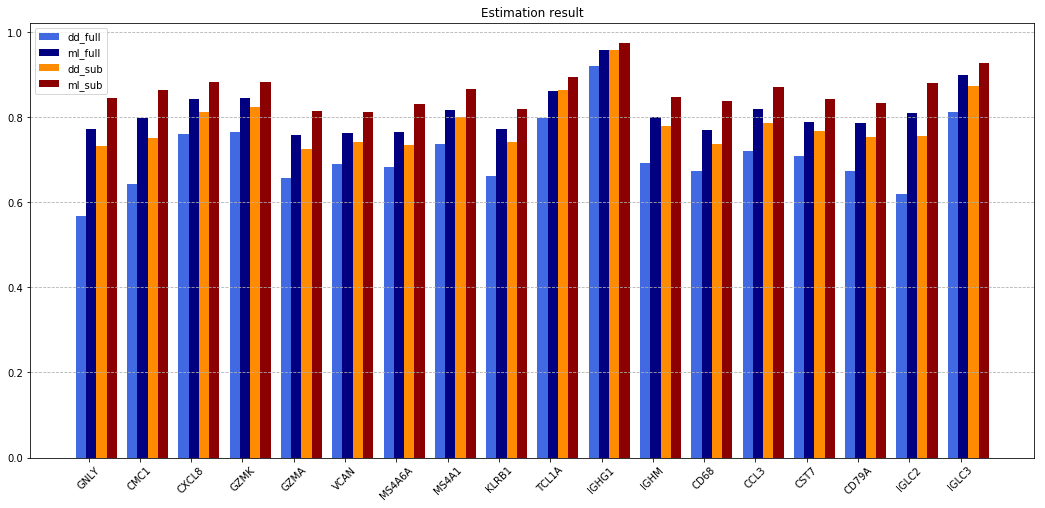

In [32]:
color_list = ['royalblue','navy','darkorange','darkred']
n_gene = len(gene_list)
plt.figure(figsize=[18,8])

plt.bar(np.arange(n_gene)+0.1,p0_dd_full,width=0.2,color=color_list[0],label='dd_full')
plt.bar(np.arange(n_gene)+0.3,p0_ml_full,width=0.2,color=color_list[1],label='ml_full')
plt.bar(np.arange(n_gene)+0.5,p0_dd_sub,width=0.2,color=color_list[2],label='dd_sub')
plt.bar(np.arange(n_gene)+0.7,p0_ml_sub,width=0.2,color=color_list[3],label='ml_sub')
plt.xticks(np.arange(n_gene)+0.25,gene_list,rotation=45)
plt.title('Estimation result')
plt.legend()
plt.grid(axis='y',linestyle='--')
plt.savefig(output_folder+'/zero_estimation_high_expressed_gene.pdf')
plt.savefig(output_folder+'/zero_estimation_high_expressed_gene.png')
plt.show()
plt.close('all')

# Zero component analysis
The marker genes are selected from page 5 in the paper 'Massively parallel digital transcriptional profiling of single cells'. Some important genes are:
- CD3D: enriched in T cells, >80%
- NKG7: enriched in NK cells, ~6%
- CD79A: enriched in B cells, ~6%
- S100A8,S100A9: enriched in myeloid cells, ~7%

In [3]:
# marker_gene_list = ['CD3D','CD3G','CD3E','CD8A','NKG7','FCER1A','CD16','S100A8','CD79A','S100A9','CCR10','TNFRSF18',\
#                    'ID3','FCER1A25','PF4','CD34','CLEC9A','GZMK','SIGLEC7','GNLY','LGALS3','CD4','CLEC4C',\
#                    'PTCRA','CD8B','ID3']

marker_gene_list = ['CD3D','CD3G','CD3E','CD8A','NKG7','FCER1A','CD16','S100A8','CD79A','S100A9','CCR10','TNFRSF18',\
                   'ID3','FCER1A25','PF4','CD34','CLEC9A','GZMK','SIGLEC7','GNLY','LGALS3','CD4','CLEC4C',\
                   'PTCRA','CD8B','ID3']

gene_list = []
for gene in marker_gene_list:
    if gene in data.var_names:
        gene_list.append(gene)

In [4]:
n_gene = len(gene_list)
plt.figure(figsize=[80,12])
for i_gene,gene in enumerate(gene_list):
    Y = np.array(data[:,gene].X)
    Y_sub = np.array(data_subsample[:,gene].X)    
    plt.subplot(2,n_gene,i_gene+1)
    plt.title('%s, Nr_bar=%0.2f'%(gene,Y.mean()))
    bins_ = np.linspace(-0.5,Y.max()+0.5,int(Y.max()+2))
    plt.hist(Y,bins=bins_)
    plt.subplot(2,n_gene,i_gene+1+n_gene)
    plt.hist(Y_sub,bins=bins_)
    plt.title('%s, Nr_bar=%0.2f'%(gene,Y_sub.mean()))
# plt.show()
plt.savefig(output_folder+'/histogram_marker_gene.png')
plt.savefig(output_folder+'/histogram_marker_gene.png')
plt.close('all')

In [5]:
p0_ml_full,p0_dd_full = sd.dd_zero_prob(data[:,gene_list],verbose=True)
p0_ml_sub,p0_dd_sub = sd.dd_zero_prob(data_subsample[:,gene_list],verbose=True)

# time start: 0.0s
n_cell=68579, n_gene=12
# total time: 0.0s
# time start: 0.0s
n_cell=68579, n_gene=12
# total time: 0.0s


In [6]:
color_list = ['royalblue','navy','darkorange','darkred']
n_gene = len(gene_list)
plt.figure(figsize=[18,8])

plt.bar(np.arange(n_gene)+0.1,p0_dd_full,width=0.2,color=color_list[0],label='dd_full')
plt.bar(np.arange(n_gene)+0.3,p0_ml_full,width=0.2,color=color_list[1],label='ml_full')
plt.bar(np.arange(n_gene)+0.5,p0_dd_sub,width=0.2,color=color_list[2],label='dd_sub')
plt.bar(np.arange(n_gene)+0.7,p0_ml_sub,width=0.2,color=color_list[3],label='ml_sub')
plt.xticks(np.arange(n_gene)+0.25,gene_list,rotation=45)
plt.title('Estimation result')
plt.legend()
plt.grid(axis='y',linestyle='--')
plt.savefig(output_folder+'/zero_estimation_marker_gene.png')
# plt.show()
plt.close('all')

In [20]:
1-2200/4000

0.44999999999999996

In [18]:
1-4500/8381

0.4630712325498151

# distribution 

In [74]:
for val in data.var_names:
    print(val)

RPL22
RPL11
SH3BGRL3
CD52
RPS8
JUN
RPL5
S100A9
S100A8
S100A6
S100A4
RPS27
H3F3A
RPS7
RPS27A
TMSB10
IGKC
RPL31
EEF1B2
RPL37A
PTMA
RPL32
RPL15
RPSA
RPL14
RPL29
RPL24
RPL35A
RPL9
RPL34
RPS3A
RPL37
RPS23
CD74
RPS14
DUSP1
GNB2L1
HLA-A
HLA-C
HLA-B
LTB
HLA-DRA
HLA-DRB1
RPS18
RPS10
RPL10A
EEF1A1
RPS12
ACTB
TMSB4X
RPS4X
RPL36A
RPL39
RPL10
RPS20
RPL7
RPL30
PABPC1
EEF1D
RPL8
RPS6
RPL35
RPL12
RPL7A
RPLP2
RPL27A
RPS13
FTH1
FAU
MALAT1
CFL1
RPS3
RPS25
RPS24
GAPDH
PFDN5
HNRNPA1
RPL41
NACA
LYZ
BTG1
RPL6
RPLP0
RPL21
TPT1
RPS29
FOS
SERF2
B2M
RPL4
RPLP1
RPS17
RPS2
RPS15A
CYBA
RPL13
PFN1
RPL26
RPL23A
RPL23
RPL19
EIF1
RPL27
RPL38
H3F3B
ACTG1
CST3
ATP5E
RPS21
RPS15
OAZ1
EEF2
RPL36
RPS28
JUNB
RPL18A
UBA52
TYROBP
RPS16
RPS19
RPL18
FTL
RPL13A
RPS11
RPS9
RPL28
RPS5
RPL3
MT-ND1
MT-ND2
MT-CO1
MT-CO2
MT-ATP6
MT-CO3
MT-ND3
MT-ND4
MT-ND5
MT-CYB


SH3BGRL3


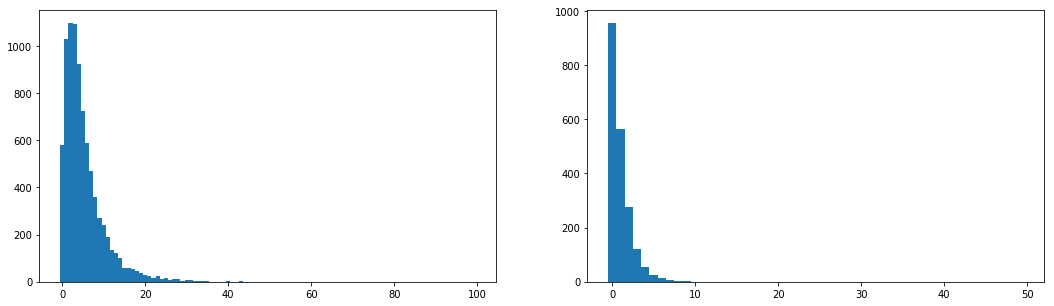

CD52


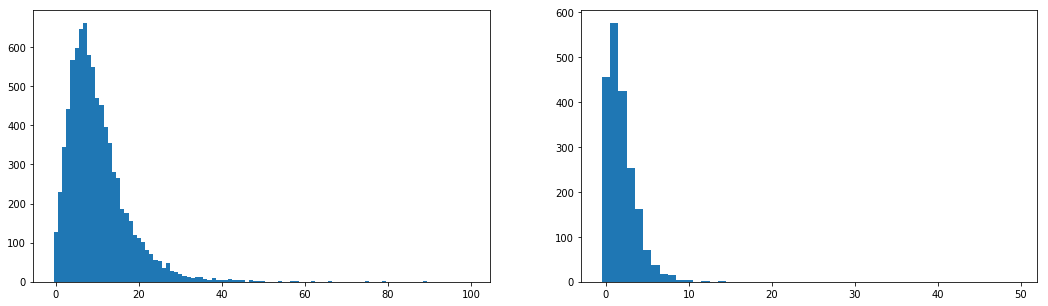

JUN


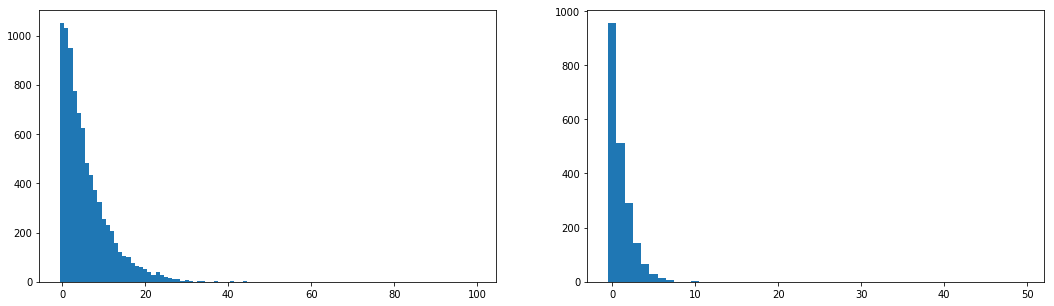

S100A9


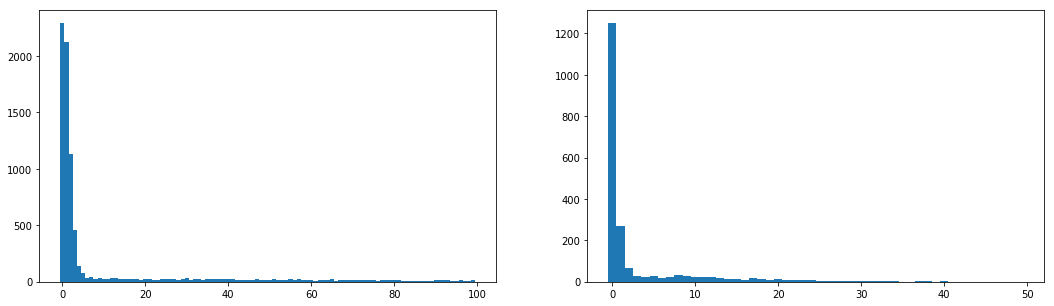

S100A8


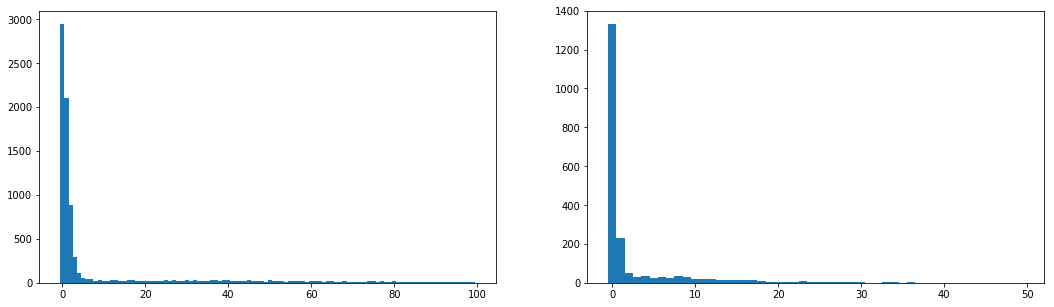

S100A6


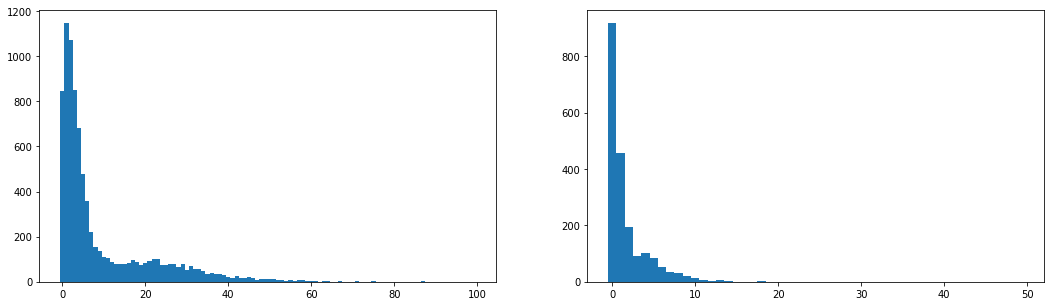

S100A4


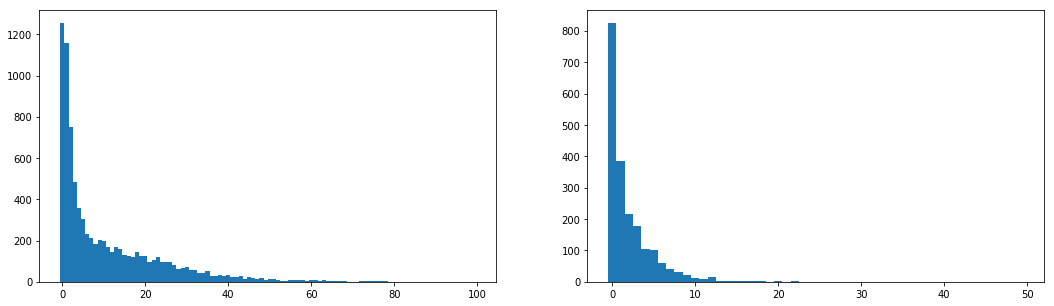

H3F3A


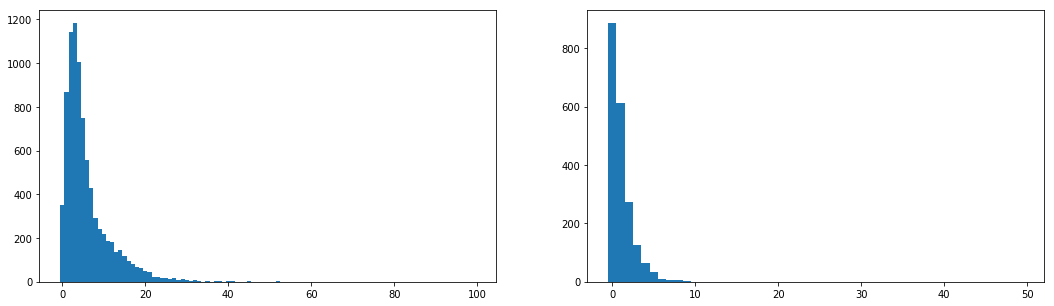

TMSB10


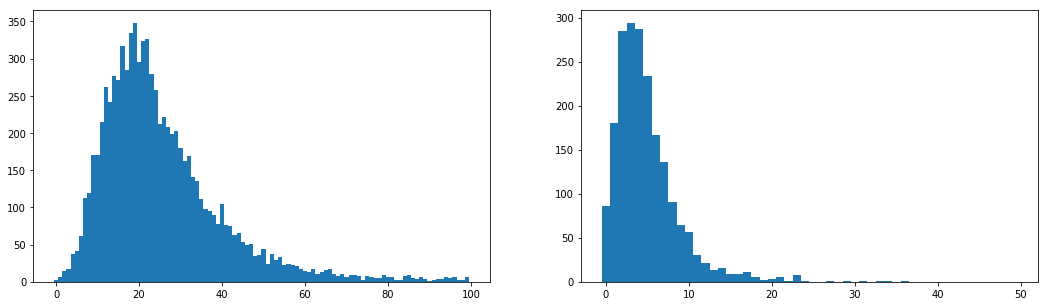

IGKC


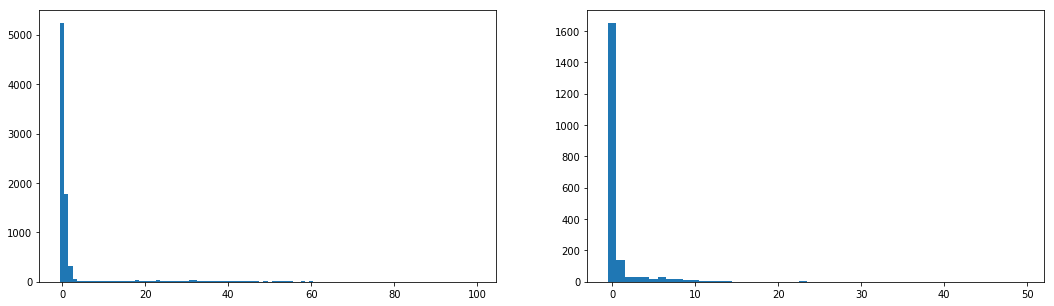

EEF1B2


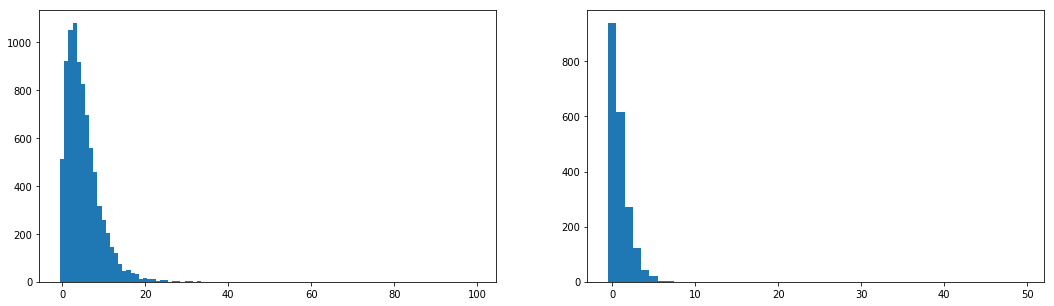

PTMA


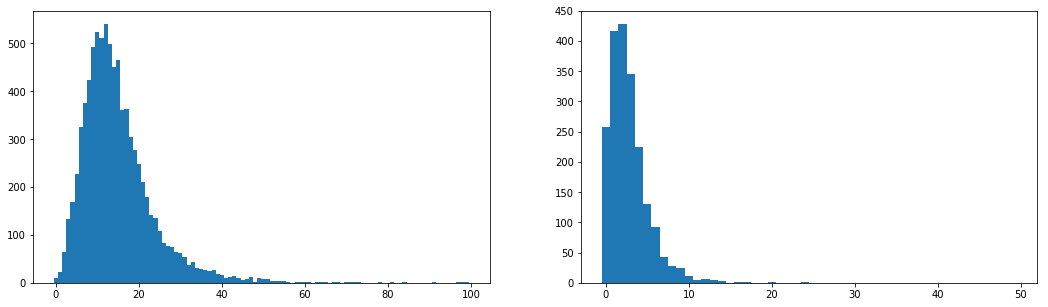

CD74


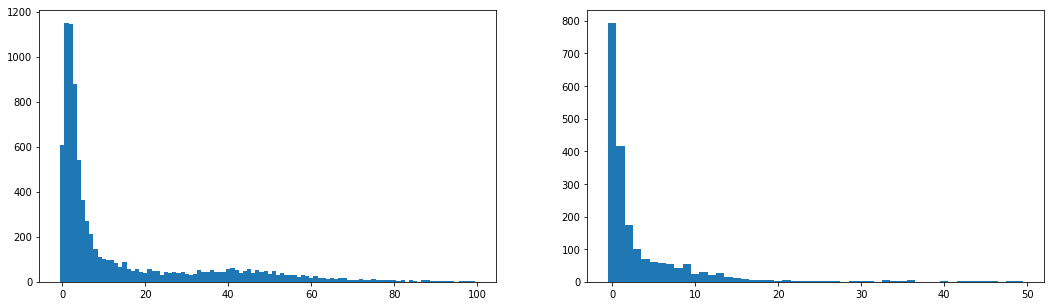

DUSP1


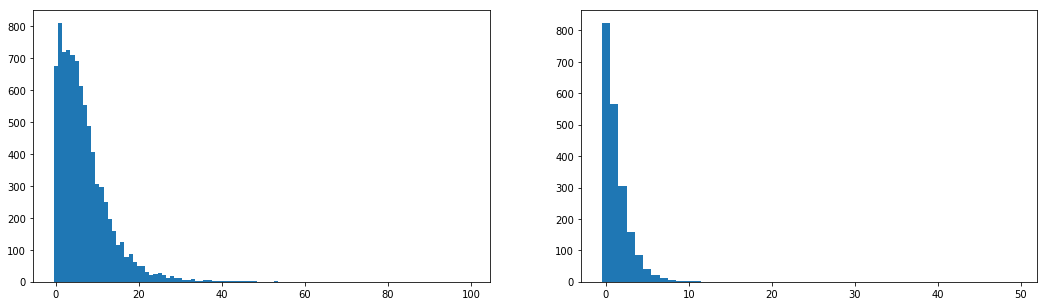

GNB2L1


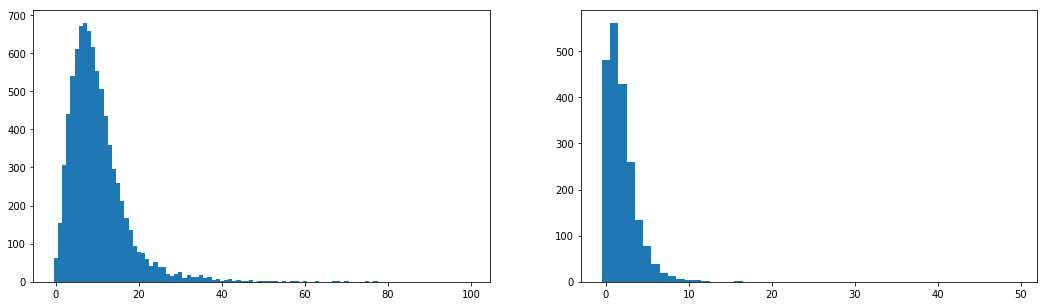

HLA-A


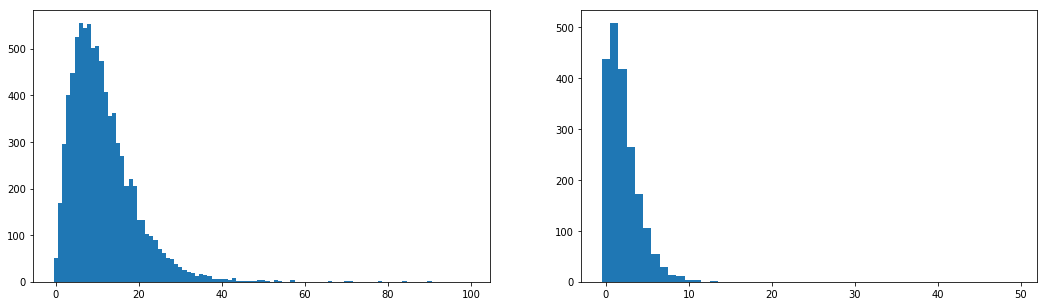

HLA-C


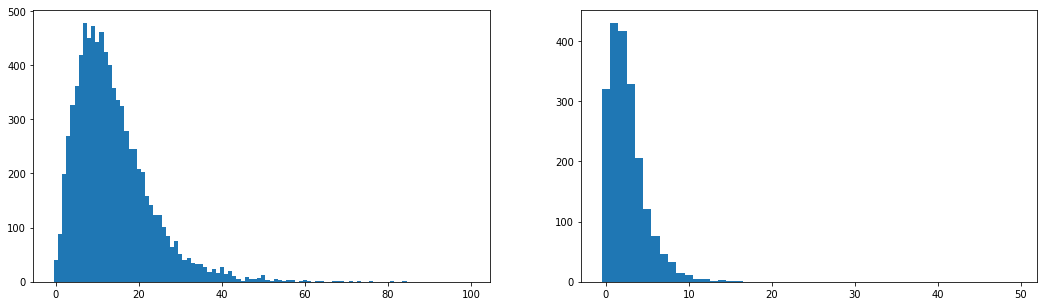

HLA-B


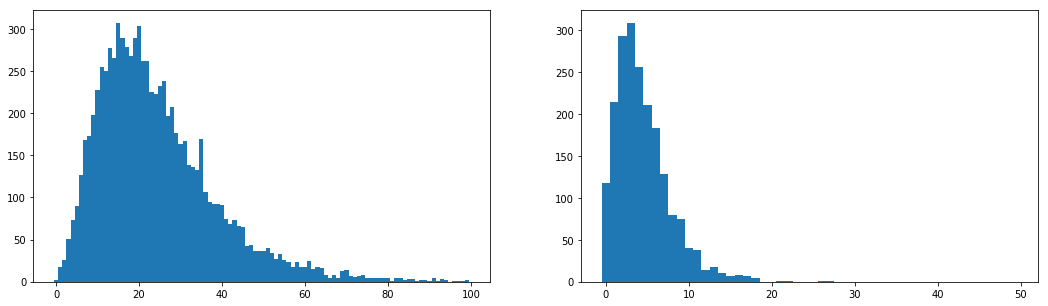

LTB


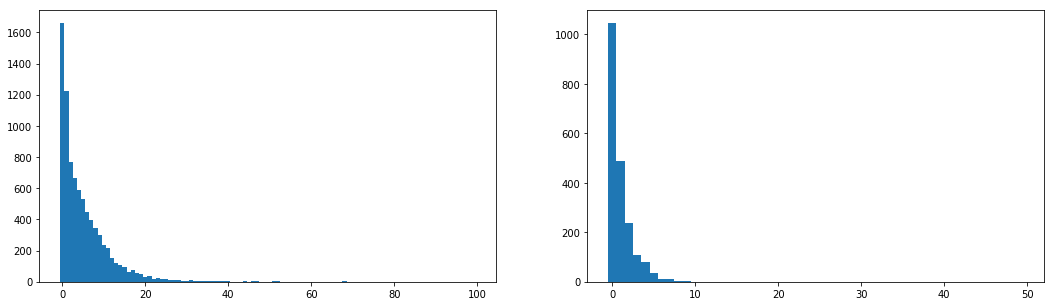

HLA-DRA


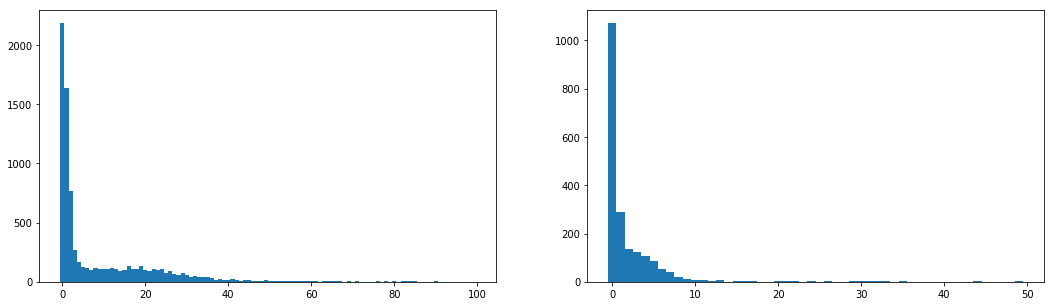

HLA-DRB1


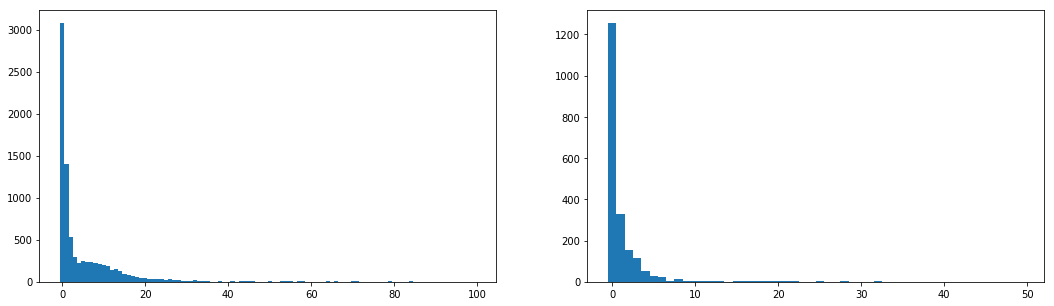

EEF1A1


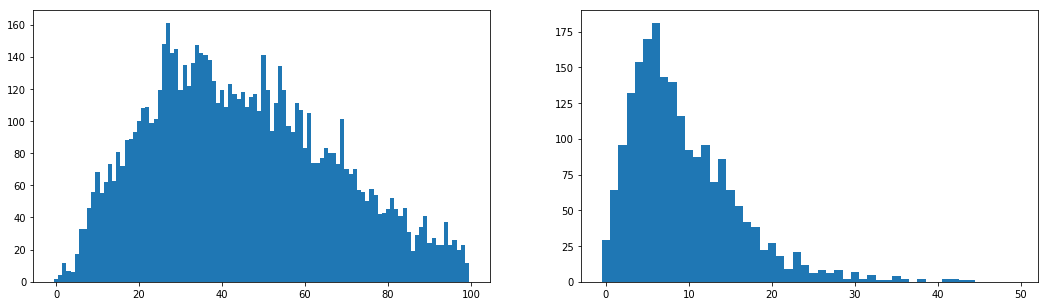

ACTB


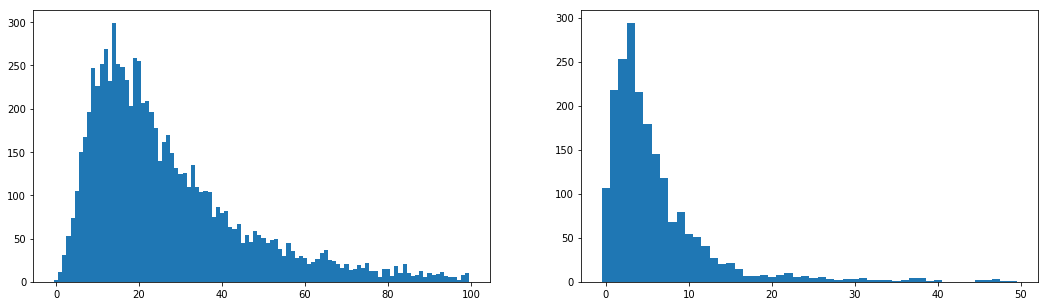

TMSB4X


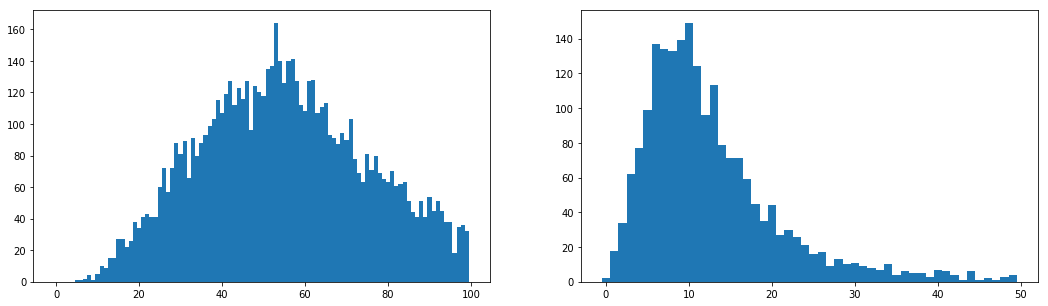

PABPC1


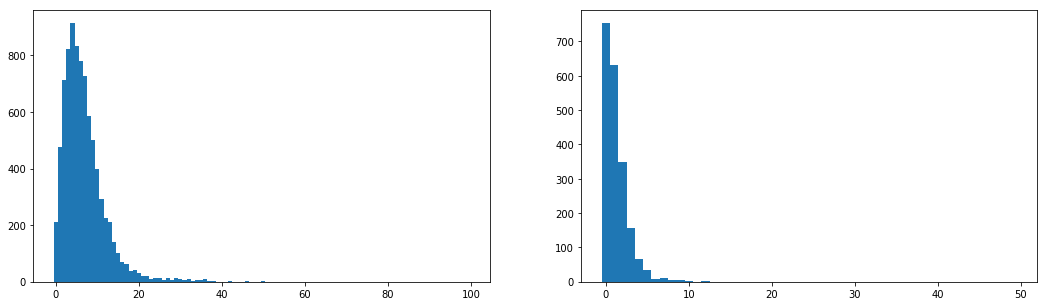

EEF1D


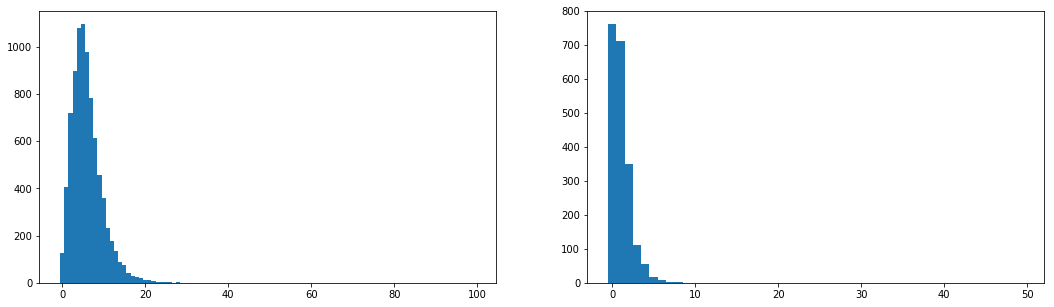

FTH1


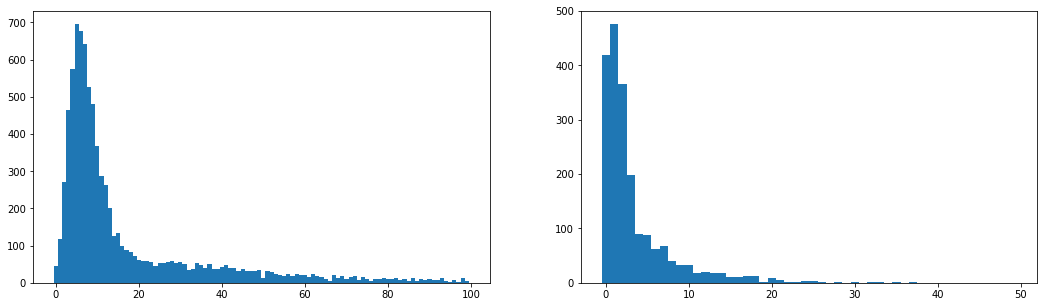

FAU


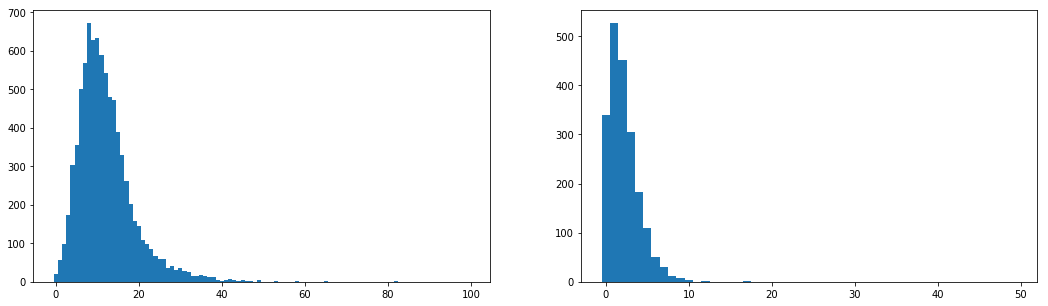

MALAT1


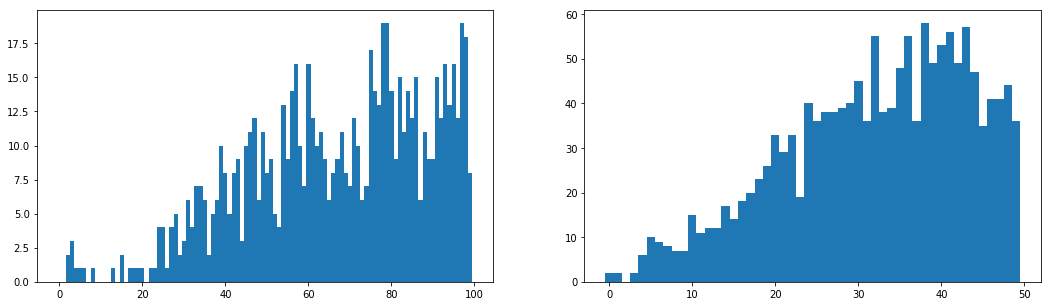

CFL1


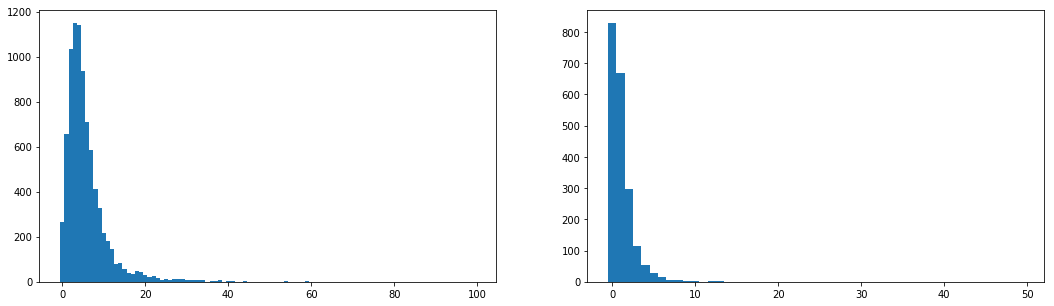

GAPDH


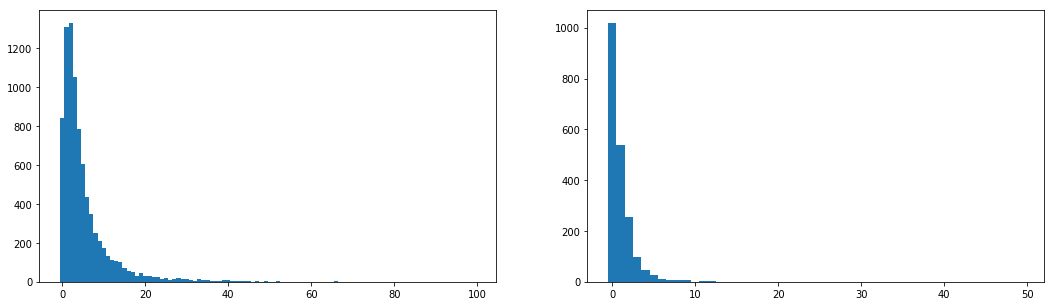

PFDN5


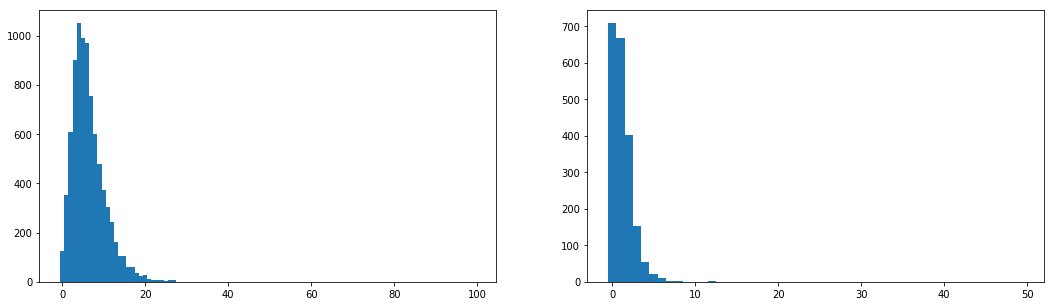

HNRNPA1


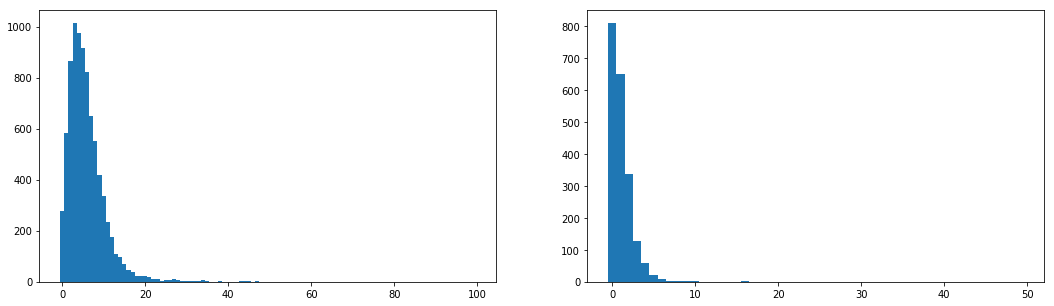

NACA


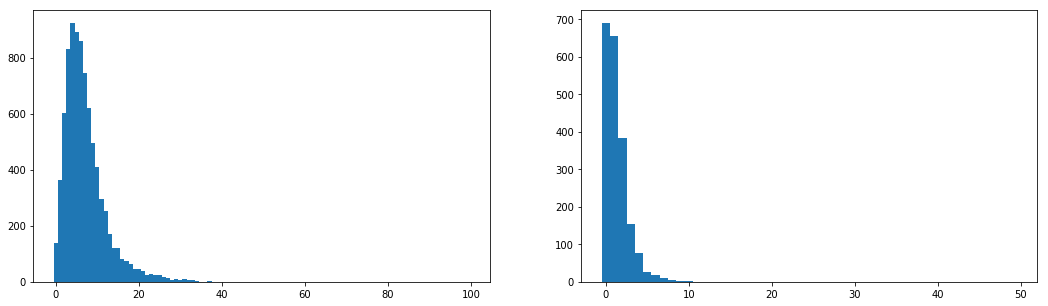

LYZ


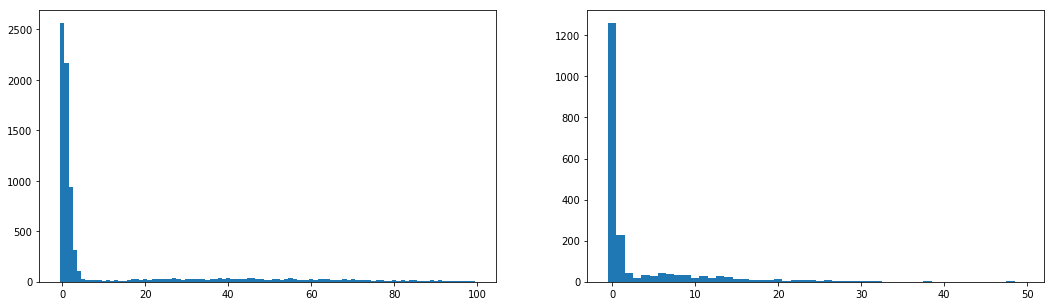

BTG1


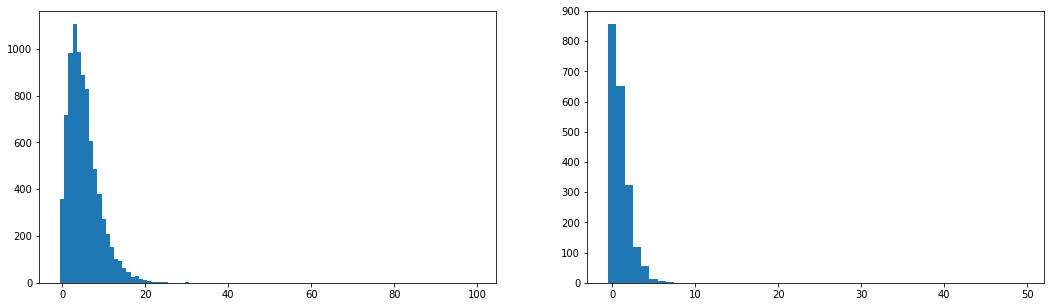

TPT1


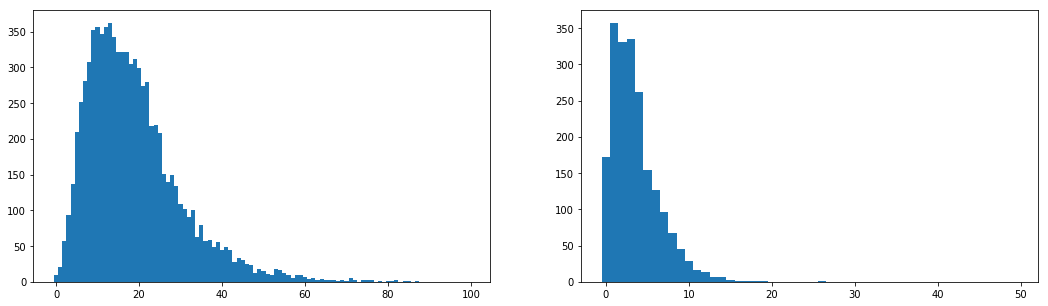

FOS


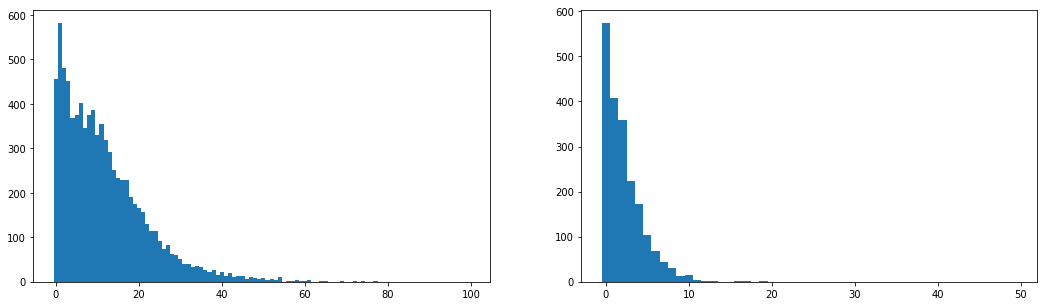

SERF2


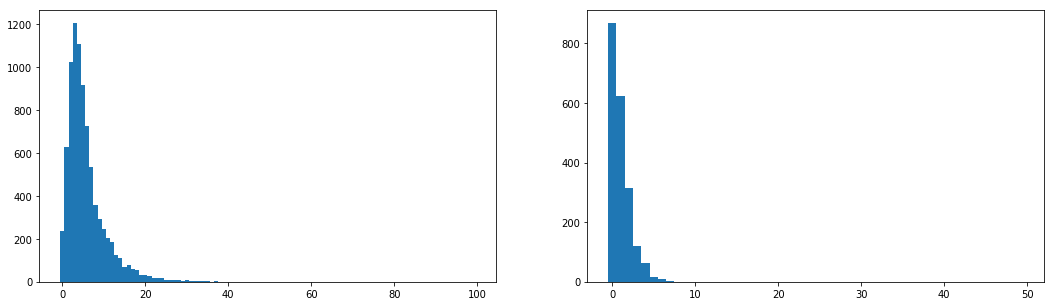

B2M


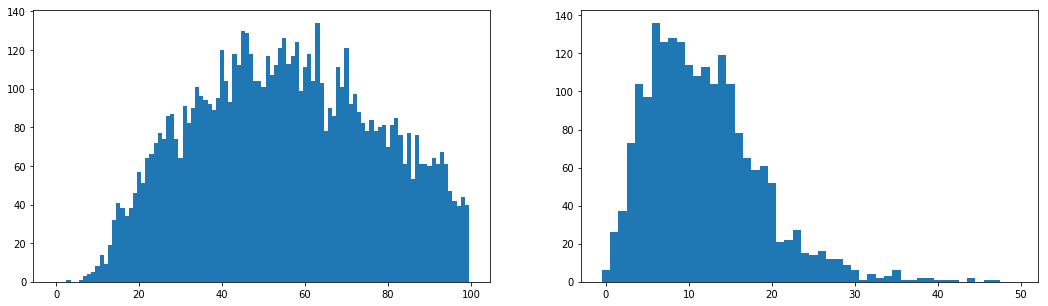

CYBA


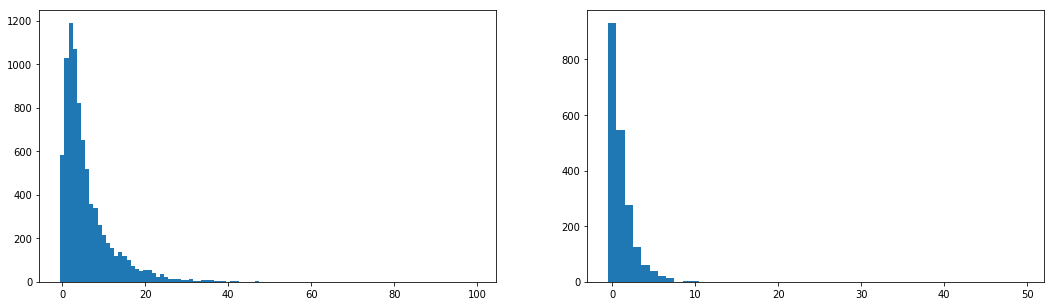

PFN1


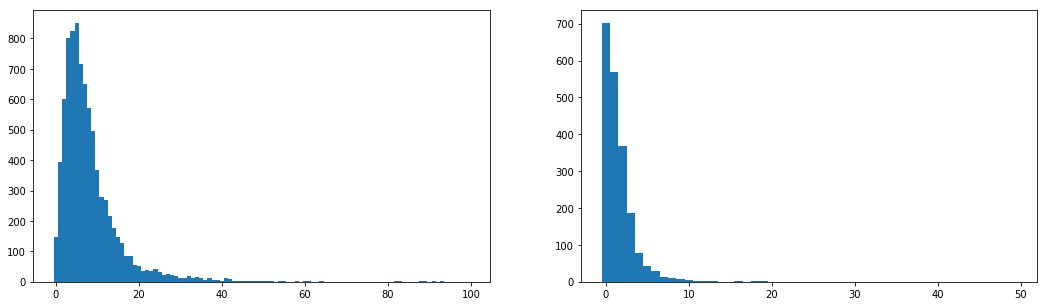

EIF1


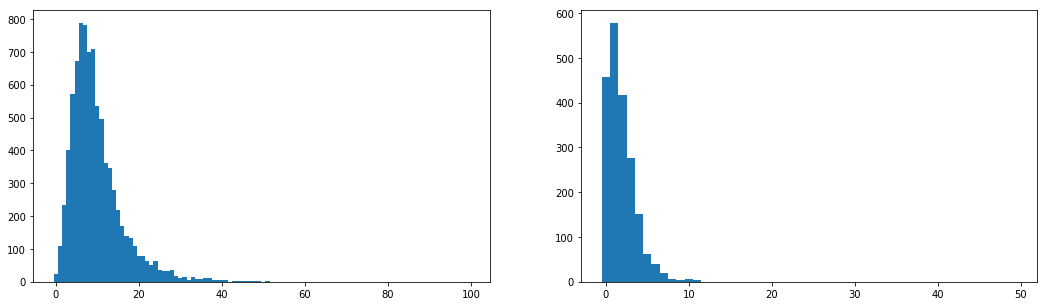

H3F3B


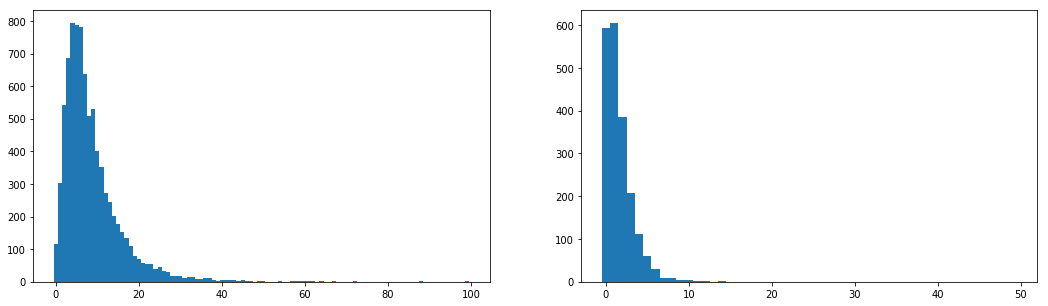

ACTG1


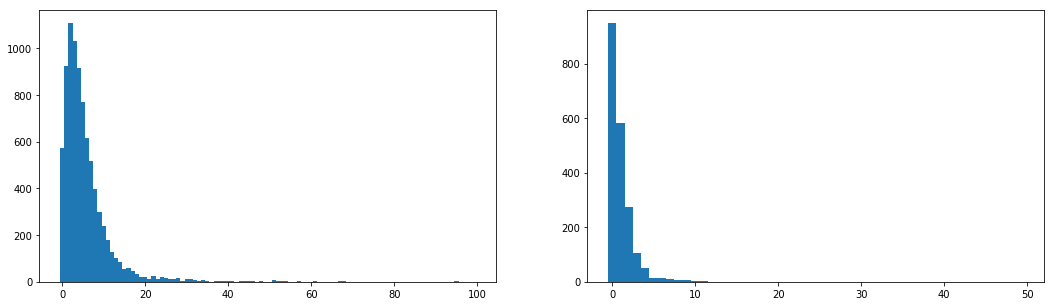

CST3


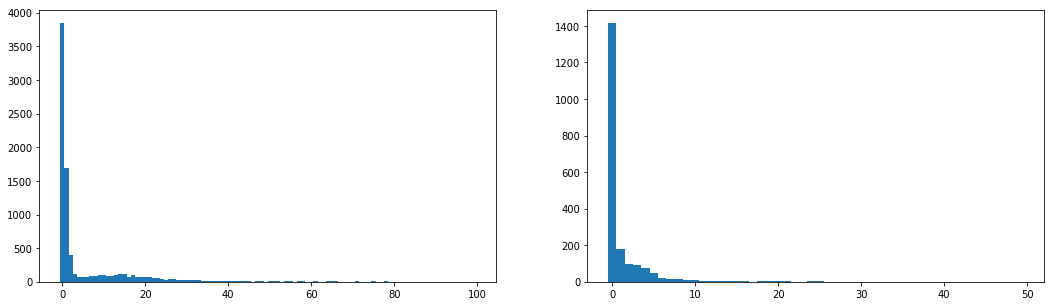

ATP5E


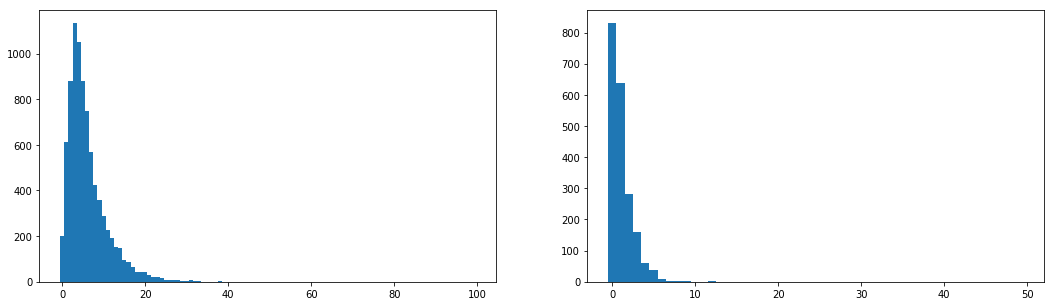

OAZ1


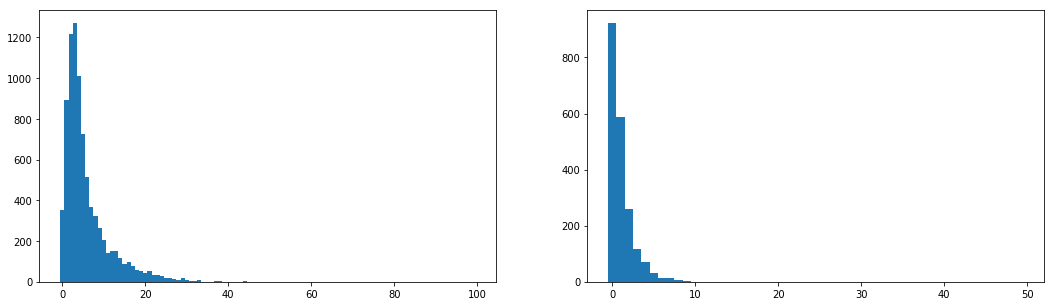

EEF2


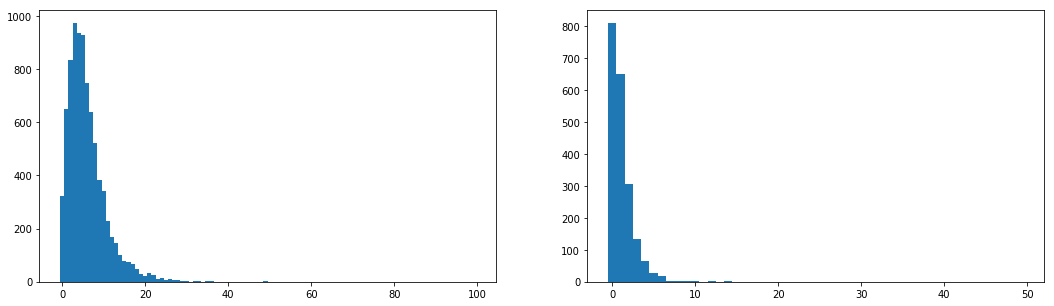

JUNB


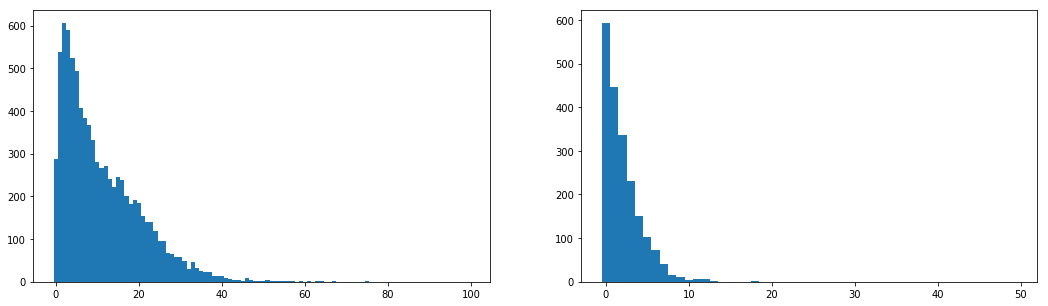

UBA52


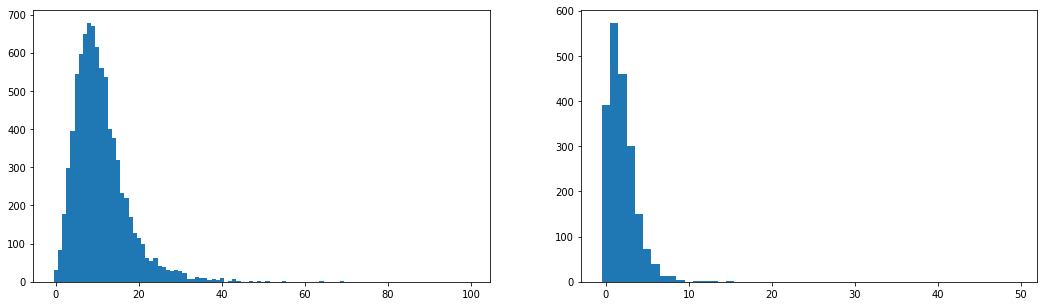

TYROBP


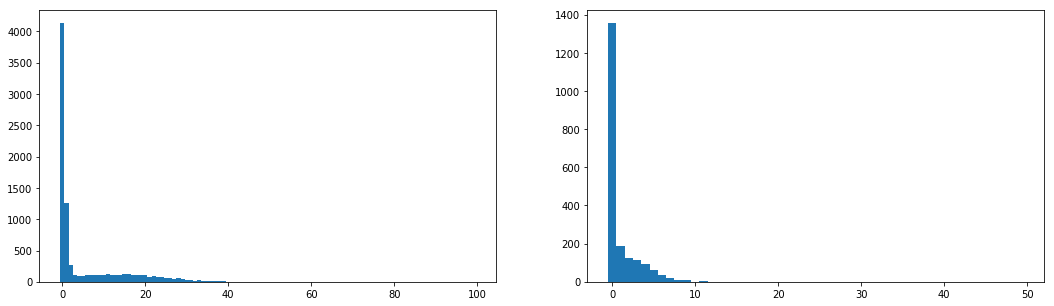

FTL


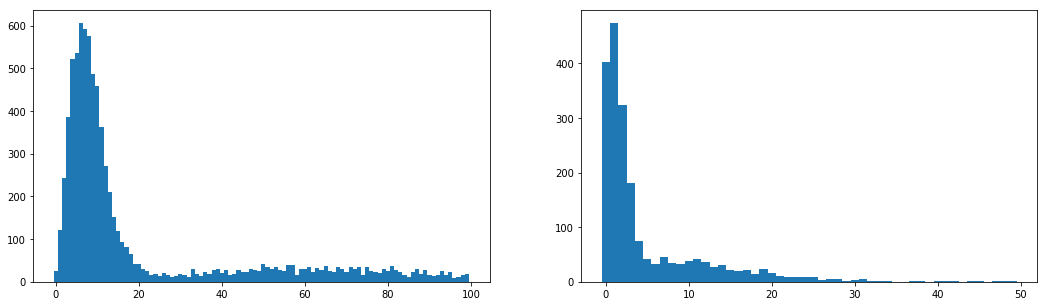

MT-ND1


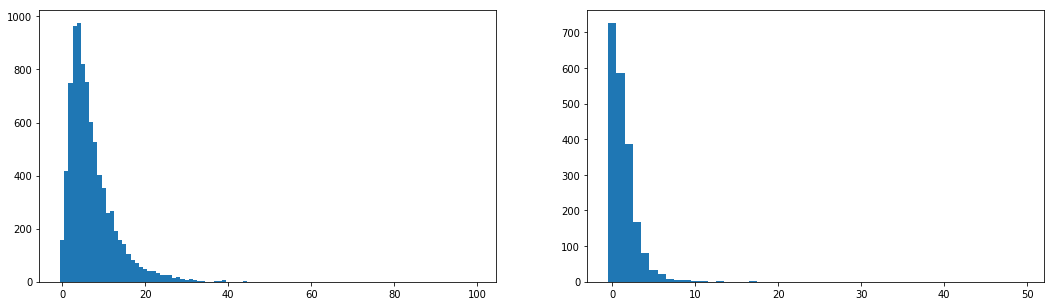

MT-ND2


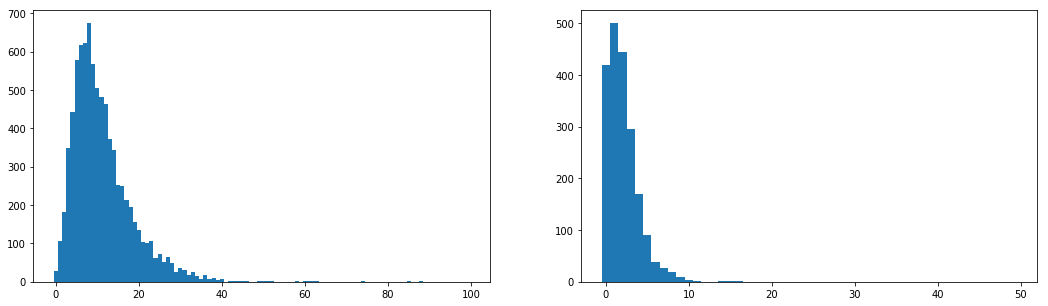

MT-CO1


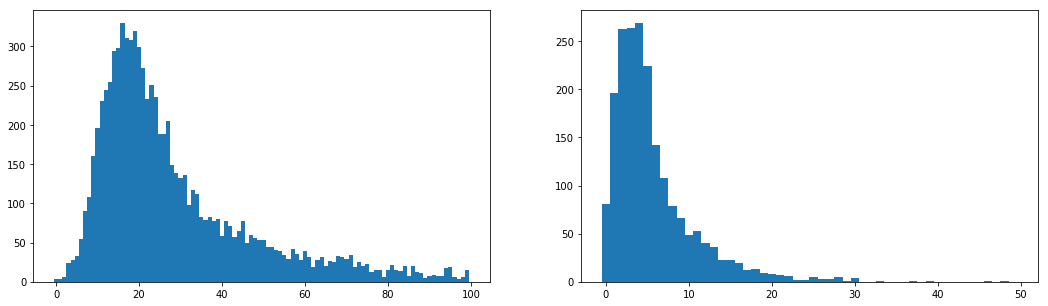

MT-CO2


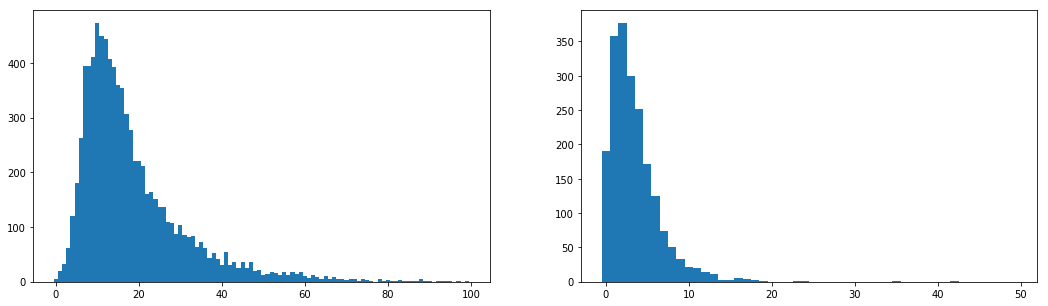

MT-ATP6


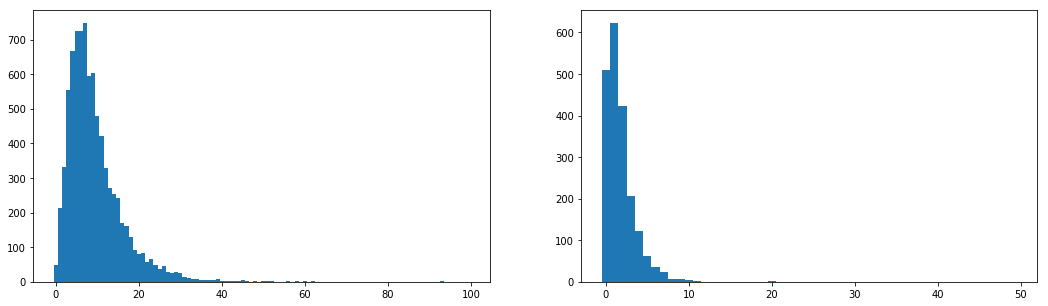

MT-CO3


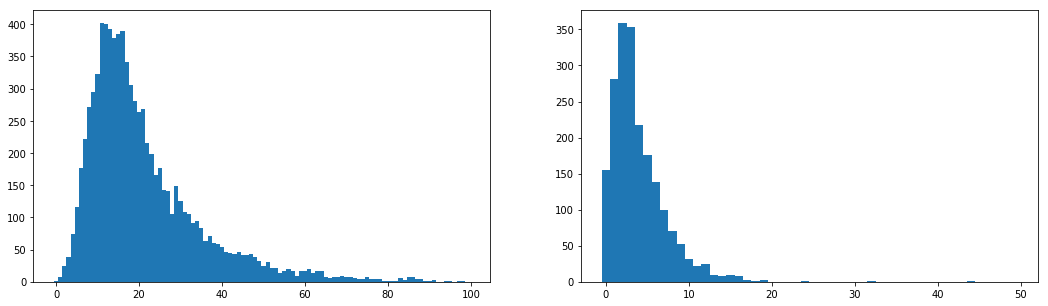

MT-ND3


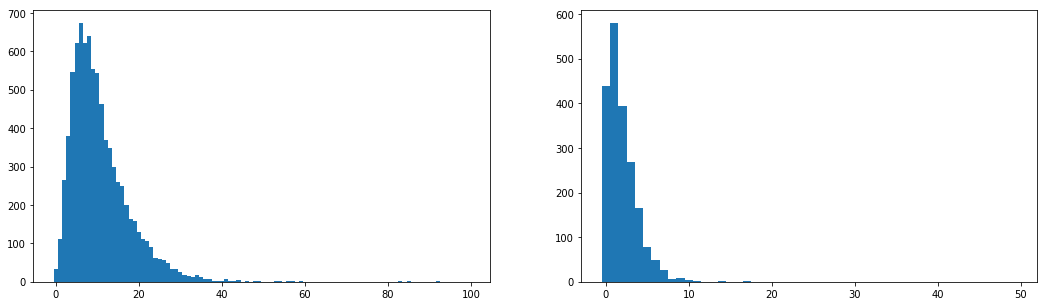

MT-ND4


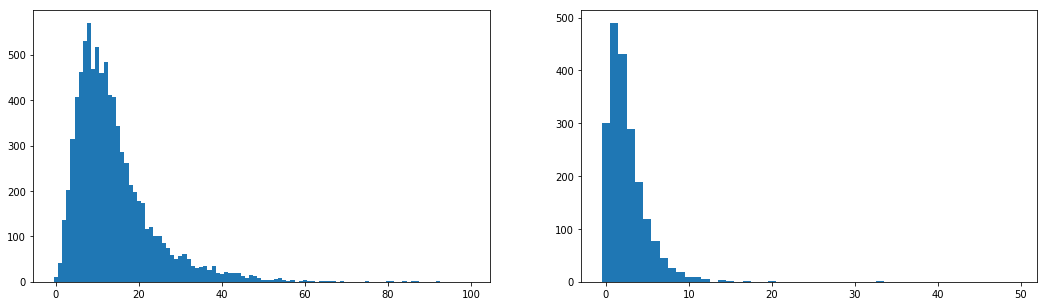

MT-ND5


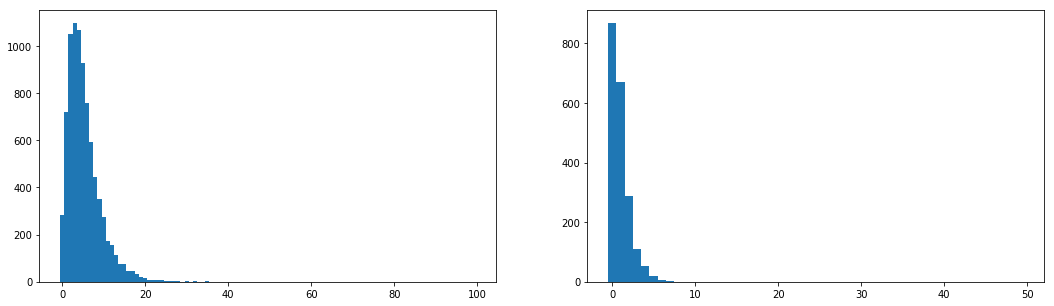

MT-CYB


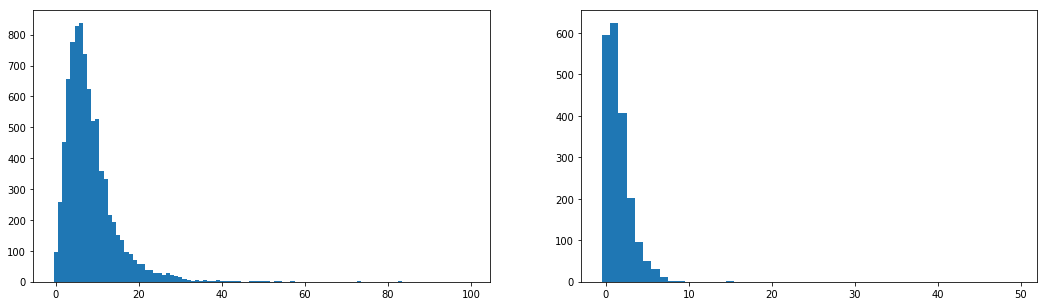

In [79]:
for val in data.var_names:
    if 'RP' not in val:
        print(val)
        genename = val
        Y = np.array(data[:,genename].X)
        Y_sub = np.array(data_subsample[:,genename].X)

        plt.figure(figsize=[18,5])
        plt.subplot(121)
        plt.hist(Y,bins=np.linspace(-0.5,99.5,101))
        plt.subplot(122)
        plt.hist(Y_sub,bins=np.linspace(-0.5,49.5,51))
        plt.show()

In [90]:
for val in data.var_names:
    if 'NKG7' in val:
        print(val)

NKG7


In [95]:
np.mean(Y==0)

0.3927932227657797

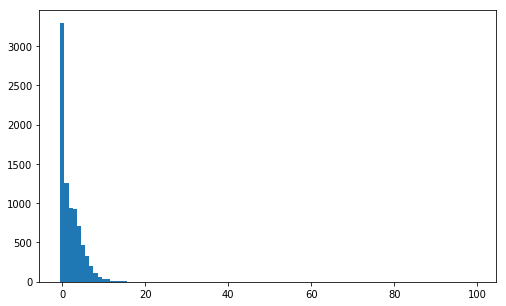

In [94]:
genename = 'CD3D'
Y = np.array(data[:,genename].X)
# Y_sub = np.array(data_subsample[:,genename].X)

plt.figure(figsize=[18,5])
plt.subplot(121)
plt.hist(Y,bins=np.linspace(-0.5,99.5,101))
# plt.subplot(122)
# plt.hist(Y_sub,bins=np.linspace(-0.5,49.5,51))
plt.show()

In [18]:
genename = 'FTL'
Y = np.array(data[:,genename].X)
Y_sub = np.array(data_subsample[:,genename].X)

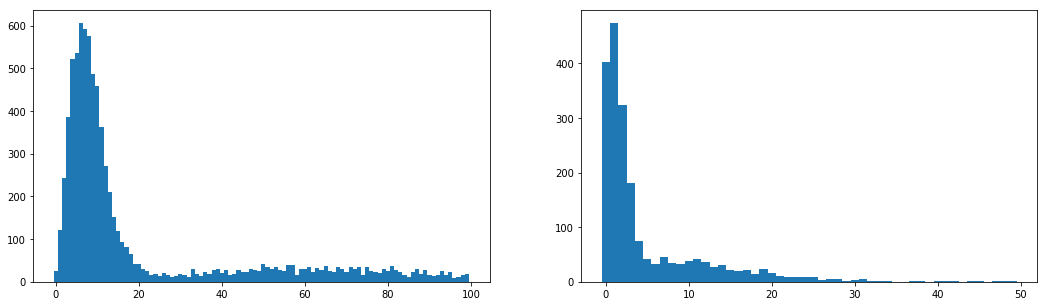

In [24]:
plt.figure(figsize=[18,5])
plt.subplot(121)
plt.hist(Y,bins=np.linspace(-0.5,99.5,101))
plt.subplot(122)
plt.hist(Y_sub,bins=np.linspace(-0.5,49.5,51))
plt.show()

In [66]:
p

array([2.64376746e-01, 7.92093011e-02, 7.98037010e-02, 9.55396175e-02,
       9.95104038e-02, 9.22944403e-02, 7.84768148e-02, 6.23953183e-02,
       4.70254547e-02, 3.39270562e-02, 2.36028847e-02, 1.59228217e-02,
       1.04620154e-02, 6.71849746e-03, 4.22888009e-03, 2.61512081e-03,
       1.59191076e-03, 9.55476753e-04, 5.66243337e-04, 3.31732785e-04,
       1.92320711e-04, 1.10435260e-04, 6.28603059e-05, 3.54923155e-05,
       1.98906392e-05, 1.10702552e-05, 6.12172235e-06, 3.36501877e-06,
       1.83937826e-06, 1.00018334e-06, 5.41195347e-07, 2.91489228e-07,
       1.56315450e-07, 8.34832235e-08, 4.44132494e-08, 2.35413923e-08,
       1.24348671e-08, 6.54660840e-09, 3.43580788e-09, 1.79781330e-09,
       9.38047349e-10, 4.88119755e-10, 2.53339320e-10, 1.31160490e-10,
       6.77445065e-11, 3.49107535e-11, 1.79514368e-11, 9.21154228e-12,
       4.71731232e-12, 2.41112629e-12, 1.23009965e-12, 6.26449105e-13,
       3.18482045e-13, 1.61645912e-13, 8.19125841e-14, 4.14444935e-14,
      

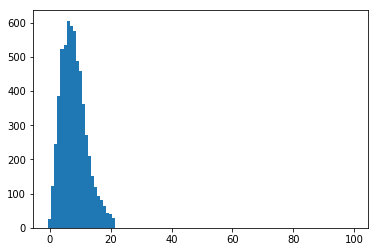

6.90275397219896 0.5362033059179445


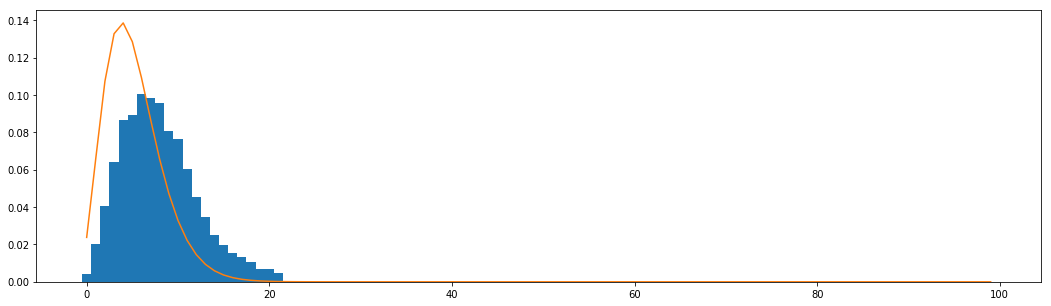

In [70]:
Y_temp = Y[Y<22]
r,p = fit_nb(Y_temp)
x_v = np.arange(100)
p = nbinom.pmf(x_v,r,p)
plt.figure(figsize=[18,5])
plt.hist(Y_temp,bins=np.linspace(-0.5,99.5,101),weights=np.ones([Y_temp.shape[0]])/Y_temp.shape[0])
plt.plot(x_v,p)
plt.show()

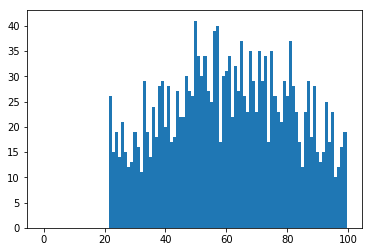

3.4642274827219914 0.95724917436304


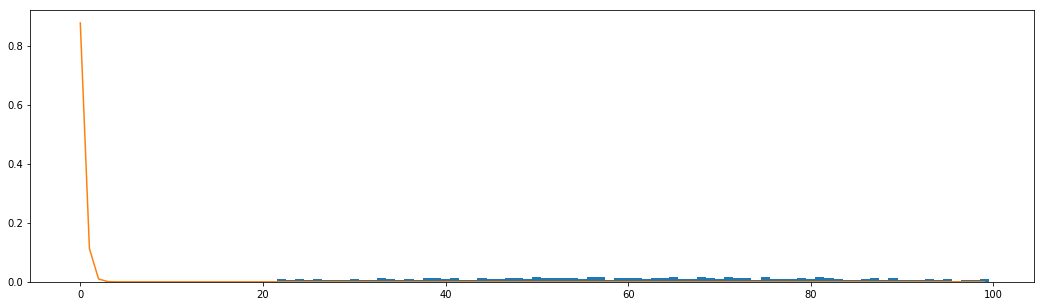

In [71]:
Y_temp = Y[Y>=22]
r,p = fit_nb(Y_temp)
x_v = np.arange(100)
p = nbinom.pmf(x_v,r,p)
plt.figure(figsize=[18,5])
plt.hist(Y_temp,bins=np.linspace(-0.5,99.5,101),weights=np.ones([Y_temp.shape[0]])/Y_temp.shape[0])
plt.plot(x_v,p)
plt.show()

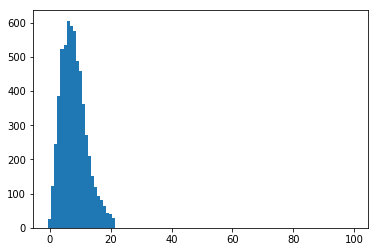

6.90275397219896 0.5362033059179445


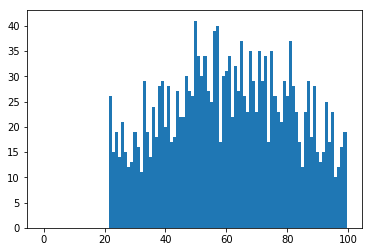

3.4642274827219914 0.95724917436304


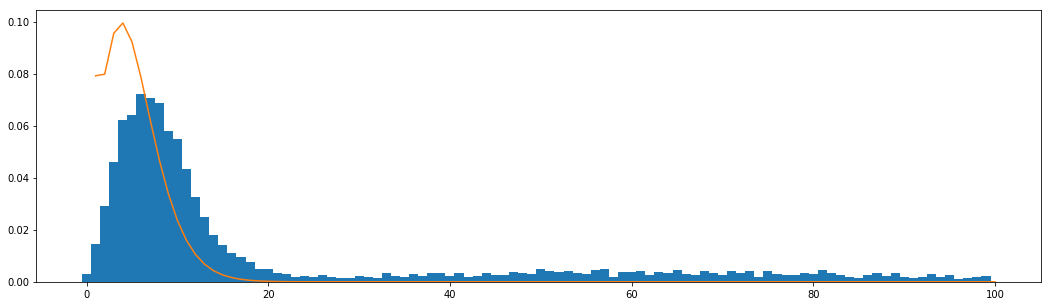

In [67]:
r1,p1 = fit_nb(Y[Y<22])
w1 = np.mean(Y<22)
r2,p2 = fit_nb(Y[Y>=22])
w2 = np.mean(Y>=22)



x_v = np.arange(100)+1
p = nbinom.pmf(x_v,r1,p1)*w1 + nbinom.pmf(x_v,r2,p2)*w2 

plt.figure(figsize=[18,5])
plt.hist(Y,bins=np.linspace(-0.5,99.5,101),weights=np.ones([Y.shape[0]])/Y.shape[0])
plt.plot(x_v,p)
plt.show()

In [61]:
## 
from scipy.stats import nbinom
def fit_nb(X,weight=None):
    if weight is None:
        weight = np.ones([X.shape[0]])
    plt.figure()
    plt.hist(X,weights=weight,bins=np.linspace(-0.5,99.5,101))
    plt.show()
    mean = np.sum(X*weight)/np.sum(weight)
    variance = np.sum((X-mean)**2*weight)/np.sum(weight)
    p = 1-mean/variance
    r = mean*(1-p)/p
    print(r,p)
    return int(r),p

def fit_nb_mixture(X):
    n_sample = X.shape[0]
    w = np.zeros([2,n_sample],dtype=float) + 0.5
    w_old = np.zeros([2,n_sample],dtype=float) 
    p = np.array([0.5,0.1])
    r = np.array([1,20])
    q = 0.5
    
    n_itr = 2
    for i in range(n_itr):
        w_old = w
        # E step
        w[0] = nbinom.pmf(X,r[0],p[0])*w_old[0]
        w[1] = nbinom.pmf(X,r[1],p[1])*w_old[1]
        w = w/w.sum(axis=0)
        w[np.isnan(w)] = 0.5
        #print(np.sum(np.isnan(w)))
        
        # M step
        r[0],p[0] = fit_nb(X,w[0])
        r[1],p[1] = fit_nb(X,w[1])
        
        print('iteration %d'%i)
        print(r[0],p[0],np.mean(w[0]))
        print(r[1],p[1],np.mean(w[1]))
        
    return 

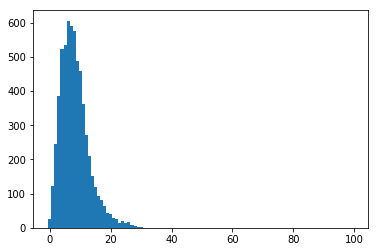

5.127070927773543 0.6171862693088824


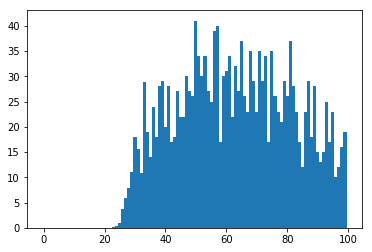

3.8163870533701543 0.9545087719413923
iteration 0
5 0.6171862693088824 0.7307548718434588
3 0.9545087719413923 0.26924512815654145


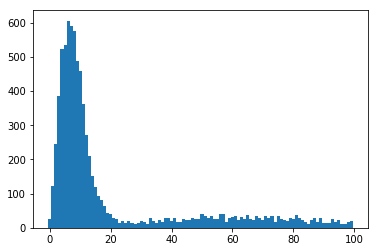

0.5158707399321605 0.9816523940135157


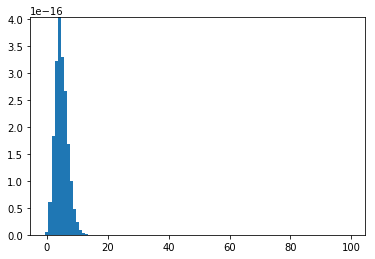

-43.65330786384003 -0.12094736865135758
iteration 1
0 0.9816523940135157 1.0
-43 -0.12094736865135758 2.2927101448297966e-19


In [60]:
fit_nb_mixture(Y)

In [39]:
Y.shape

(8381,)